In [2]:
import numpy as np
import sympy as sp
import scipy.optimize as opt
import scipy as sc
import matplotlib.pyplot as plt
import torch.optim as optim
import tensorflow as tf
import pandas as pd
import torch
import autograd
import math
from matplotlib import cm
from time import time
from random import shuffle
from math import exp
import cProfile, pstats, tracemalloc, linecache, os

# profiling

In [54]:
def profile(call, stat_filename) :
    tracemalloc.start()

    prof = cProfile.Profile()
    snapBefore = tracemalloc.take_snapshot()
    prof.enable()
    call_data = call() # start computation to profile
    prof.disable()
    tracemalloc.stop()

    stats = pstats.Stats(prof)
    stats.dump_stats(stat_filename + ".profile")

    mem_diff = call_data["snap"].compare_to(snapBefore, 'lineno')
    total = sum(stat.size_diff for stat in mem_diff)
    print("Total allocated size: %.1f KiB" % (total / 1024))

    call_data.update({'mem' : total / 1024, 'time' : stats.get_stats_profile().total_tt})
    return call_data

# 1 пункт

## utils

In [4]:
def check_points(point1, point2, eps=1e-6):
    for i in range(len(point1)):
      if abs(point1[i] - point2[i]) > eps:
        return True
    return False

def draw_3d_function_new(points, left_limit, right_Limit, azim, dist, elev, function, names=["", ""]):
    fig = plt.figure()
    for i in range(2):
      t = np.linspace(left_limit, right_Limit, 1000)
      X, Y = np.meshgrid(t, t)
      ax = fig.add_subplot(1, 2, i+1, projection='3d')
      my_col = cm.cool(function(X, Y)/np.amax(function(X, Y))) # color of surface
      ax.plot_surface(X, Y, function(X, Y), facecolors = my_col,
                      alpha=0.8, rstride=12, cstride=12, zorder=1) # draw function surface
      X = [p[0] for p in points[i]]
      Y = [p[1] for p in points[i]]
      Z = [function(p[0], p[1]) for p in points[i]]
      ax.plot(X, Y, Z,'.', color='salmon', zorder=4, markersize=4) # draw dots of gradient_descent
      ax.plot(X, Y, Z, linewidth=0.5, color='salmon', zorder=4, label=names[i]) # draw lines beetwen dots
      ax.plot(X[0], Y[0], Z[0], 's', color='orangered', zorder=4, markersize=10) # draw entry point
      ax.plot(X[-1], Y[-1], Z[-1], 'X', color='orangered', zorder=4, markersize=10) # draw end point
      ax.set_title(names[i])
      ax.set_xlabel('x')
      ax.set_ylabel('y')
      ax.set_zlabel('z')
      ax.azim = azim
      ax.dist = dist
      ax.elev = elev
    plt.show()
  
def draw_lines_of_level(points, function, name=""):
    t = np.linspace(-7, 7, 100)
    X, Y = np.meshgrid(t, t)
    plt.plot([p[0] for p in points], [p[1] for p in points], 'o-', color='salmon', zorder=4, markersize=4) # draw dots of gradient_descent
    plt.plot([p[0] for p in points], [p[1] for p in points], linewidth=0.5, color='salmon', zorder=4, label=name) # draw lines beetwen dots
    plt.plot(points[0][0], points[0][1], 's', color='orangered', zorder=4, markersize=10) # draw entry point
    plt.plot(points[-1][0], points[-1][1], 'X', color='orangered', zorder=4, markersize=10) # draw end point
    plt.contour(X, Y, function(X, Y), levels=np.unique(sorted([function(p[0], p[1]) for p in points])))
    plt.title(name)
    plt.show()

def draw_lines_of_level_new(points, function, names=["", ""]):
    fig = plt.figure()
    for i in range(2):
      ax = fig.add_subplot(1, 2, i+1)
      t = np.linspace(-7, 7, 100)
      X, Y = np.meshgrid(t, t)
      ax.plot([p[0] for p in points[i]], [p[1] for p in points[i]], 'o-', color='salmon', zorder=4, markersize=4) # draw dots of gradient_descent
      ax.plot([p[0] for p in points[i]], [p[1] for p in points[i]], linewidth=0.5, color='salmon', zorder=4, label=names[i]) # draw lines beetwen dots
      ax.plot(points[i][0][0], points[i][0][1], 's', color='orangered', zorder=4, markersize=10) # draw entry point
      ax.plot(points[i][-1][0], points[i][-1][1], 'X', color='orangered', zorder=4, markersize=10) # draw end point
      ax.contour(X, Y, function(X, Y), levels=np.unique(sorted([function(p[0], p[1]) for p in points[i]])))
      ax.set_title(names[i])
    plt.show()

## GD

### torch GD

In [5]:
def gd_torch(theta, f, lr=0.1, max_iter=1000):
  x = torch.tensor(theta[0], requires_grad=True)
  y = torch.tensor(theta[1], requires_grad=True)
  optimizer = optim.SGD([x, y], lr=lr)
  points = [[x.item(), y.item()]]
  epoch = 0
  for i in range(max_iter):
      loss = f(x, y)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      points.append([x.item(), y.item()])
      if not check_points(points[-2], points[-1]):
          epoch = i
          print(f"loss: {loss.item()}, epoch: {i}  gd_torch")
          break
  snap = tracemalloc.take_snapshot()
  return {'th' : theta, 'pt' : points, 'iter' : epoch, 'snap' : snap}

### Russian GD

In [6]:
def gd(x, grad_f, f, lr=0.1):
    theta = np.array(x.copy())
    points = [x]
    epoch = 1
    while True:
        theta = theta - lr * np.array(grad_f(theta[0], theta[1]))
        points.append(theta)
        if not check_points(points[-2], points[-1]):
          print(f"loss: {f(theta[0], theta[1])}, epoch: {epoch}  gd")
          break
        epoch += 1
    snap = tracemalloc.take_snapshot()
    return {'th' : theta, 'pt' : points, 'iter' : epoch, 'snap' : snap}

### comparison

[-0.005629931561978552, 0.20633830650879492]
loss: 8.203568043609039e-11, epoch: 49  gd
Total allocated size: 11.5 KiB
loss: 1.4551915228366852e-10, epoch: 48  gd_torch
Total allocated size: 26.4 KiB


/tmp/ipykernel_1131/2302479400.py:28: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = dist


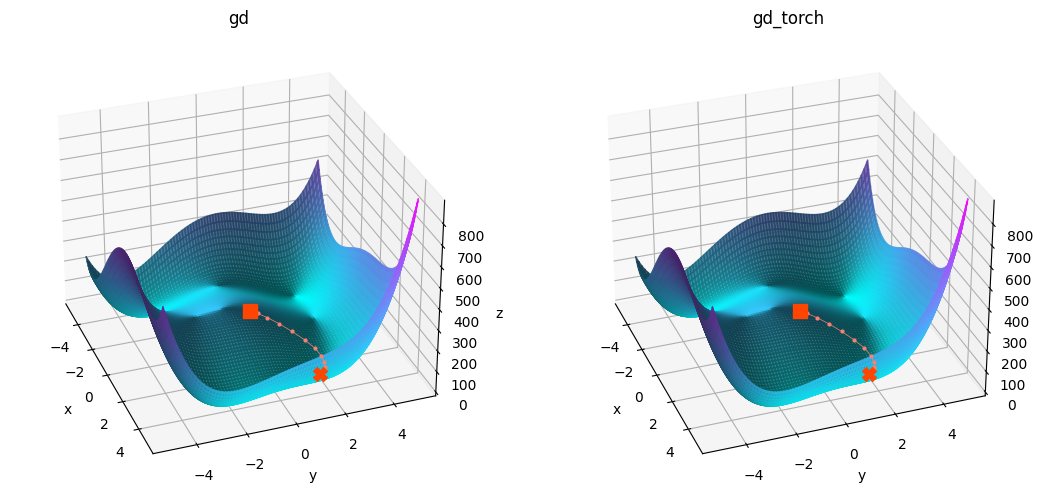

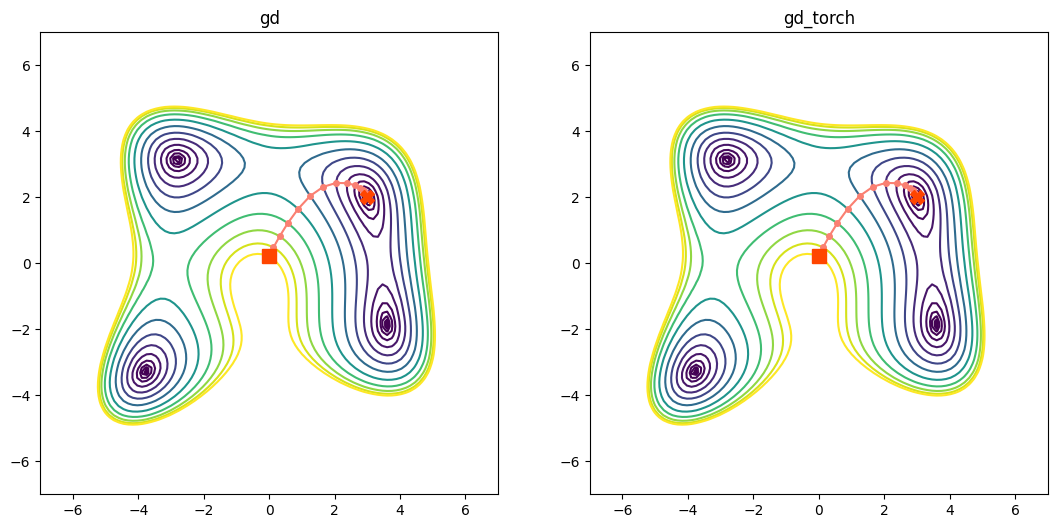

Theta  Iterations  \
gd              [2.999999033376619, 2.000002333629691]          49   
gd_torch  [-0.005629931561978552, 0.20633830650879492]          48   

          Time (sec)  Memory (KiB)  
gd             0.002     11.478516  
gd_torch       0.029     26.449219

[-5.0, 3.5]
loss: 1.6864205287642868e-12, epoch: 18  gd


RuntimeError: the tracemalloc module must be tracing memory allocations to take a snapshot

In [8]:
data_third_task = pd.DataFrame(columns=["Theta", "Iterations", "Time (sec)", "Memory (KiB)"])

def f(x, y):
    return (x ** 2 + y - 11) ** 2 + (x + y ** 2 - 7) ** 2
def grad(x, y):
    return [2 * (2 * x * (x ** 2 + y - 11) + x + y ** 2 - 7), 2 * (x ** 2 + 2 * y * (x + y ** 2 - 7) + y - 11)]

# --------------------------------------

INITIAL_THETA = [-0.005629931561978552, 0.20633830650879492]

print(INITIAL_THETA)

lr = 0.01
names=["gd", "gd_torch"]

tmp = profile(lambda: gd(INITIAL_THETA, grad, f, lr=lr), "gd")
gd_points = tmp["pt"]
data_third_task.loc["gd"] = [tmp["th"], tmp["iter"], tmp["time"], tmp["mem"]]

tmp = profile(lambda: gd_torch(INITIAL_THETA, f, lr=lr), "gd_torch")
gd_torch_points = tmp["pt"]
data_third_task.loc["gd_torch"] = [tmp["th"], tmp["iter"], tmp["time"], tmp["mem"]]

plt.rcParams["figure.figsize"] = (13,8)
draw_3d_function_new([gd_points, gd_torch_points], -5, 5, -20, 10, 30, f, names=names)

plt.rcParams["figure.figsize"] = (13,6)
draw_lines_of_level_new([gd_points, gd_torch_points], f, names=names)

display(data_third_task)

# --------------------------------------

INITIAL_THETA = [-5.0, 3.5]

print(INITIAL_THETA)

lr = 0.01
names=["gd", "gd_torch"]

gd_points = gd(INITIAL_THETA, grad, f, lr=lr)
gd_torch_points = gd_torch(INITIAL_THETA, f, lr=lr)

plt.rcParams["figure.figsize"] = (13,8)
draw_3d_function_new([gd_points, gd_torch_points], -5, 5, -20, 10, 30, f, names=names)

plt.rcParams["figure.figsize"] = (13,6)
draw_lines_of_level_new([gd_points, gd_torch_points], f, names=names)

# --------------------------------------

INITIAL_THETA = [0.0, -1.0]

print(INITIAL_THETA)

lr = 0.01
names=["gd", "gd_torch"]

gd_points = gd(INITIAL_THETA, grad, f, lr=lr)
gd_torch_points = gd_torch(INITIAL_THETA, f, lr=lr)

plt.rcParams["figure.figsize"] = (13,8)
draw_3d_function_new([gd_points, gd_torch_points], -5, 5, -20, 10, 30, f, names=names)

plt.rcParams["figure.figsize"] = (13,6)
draw_lines_of_level_new([gd_points, gd_torch_points], f, names=names)


## Momentum

### torch Mementum

In [ ]:
def gd_momentum_torch(theta, f, lr=0.1, alpha=0.9, max_iter=1000):
  x = torch.tensor(theta[0], requires_grad=True)
  y = torch.tensor(theta[1], requires_grad=True)
  optimizer = optim.SGD([x, y], lr=lr, momentum=alpha)
  points = [[x.item(), y.item()]]
  for i in range(max_iter):
      loss = f(x, y)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      points.append([x.item(), y.item()])
      if not check_points(points[-2], points[-1]):
          print(f"loss: {loss.item()}, epoch: {i}  gd_memontum_torch")
          break
  return points

### Russian Momentum

In [ ]:
def gd_momentum(x, grad_f, f, lr=0.1, alpha=0.9):
    theta = np.array(x.copy())
    points = [x]
    g = np.array([0, 0], dtype=np.float64)
    epoch = 1
    while True:
        g = alpha * g + (1 - alpha) * lr * np.array(grad_f(theta[0], theta[1]))
        theta = theta - g
        points.append(theta)
        if not check_points(points[-2], points[-1]):
          print(f"loss: {f(theta[0], theta[1])}, epoch: {epoch}  gd_momentum")
          break
        epoch += 1
    return points

### comparison

loss: 3.270289734487636e-08, epoch: 223  gd_momentum
loss: 1.0959411156363785e-09, epoch: 241  gd_memontum_torch


<ipython-input-115-063b2c8fcb53>:28: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = dist


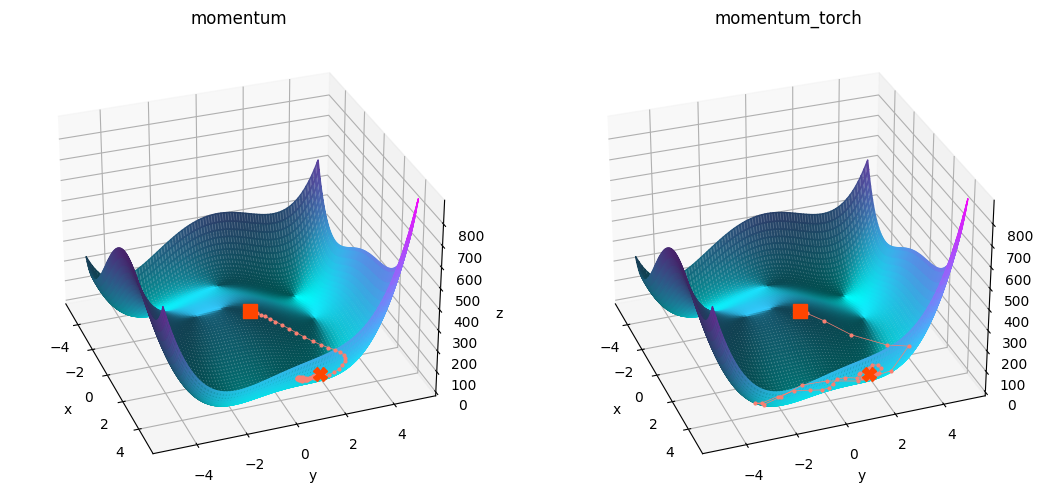

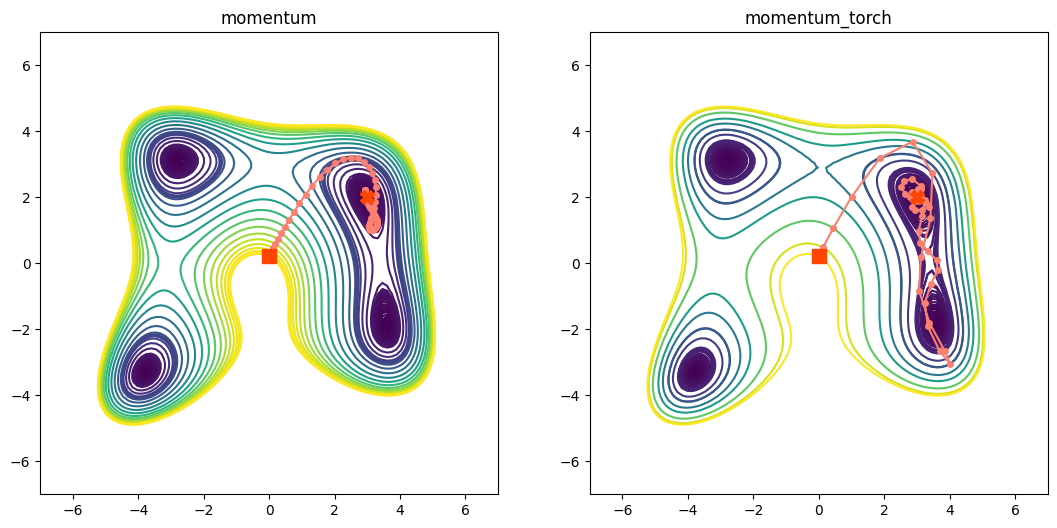

loss: 1.9440779648348076e-09, epoch: 250  gd_momentum
loss: 4.1797875383053906e-08, epoch: 221  gd_memontum_torch


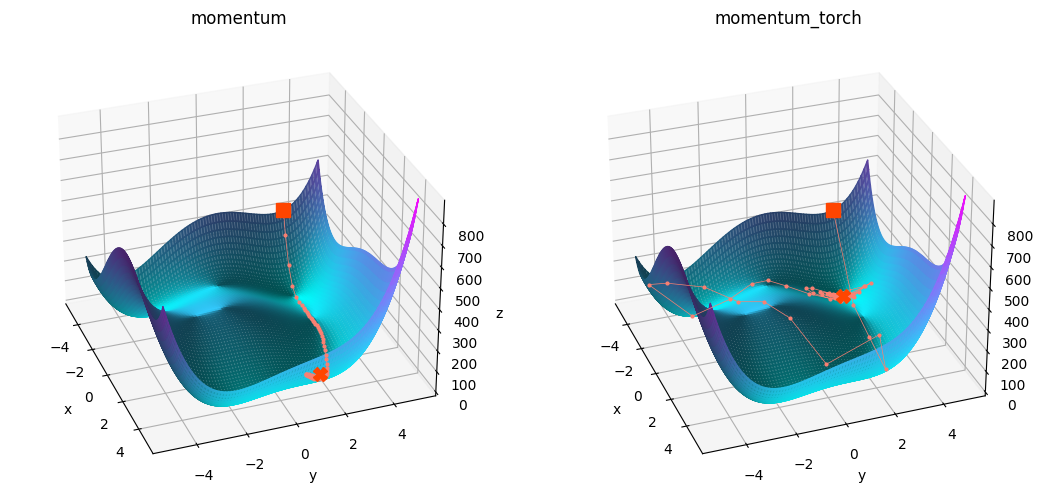

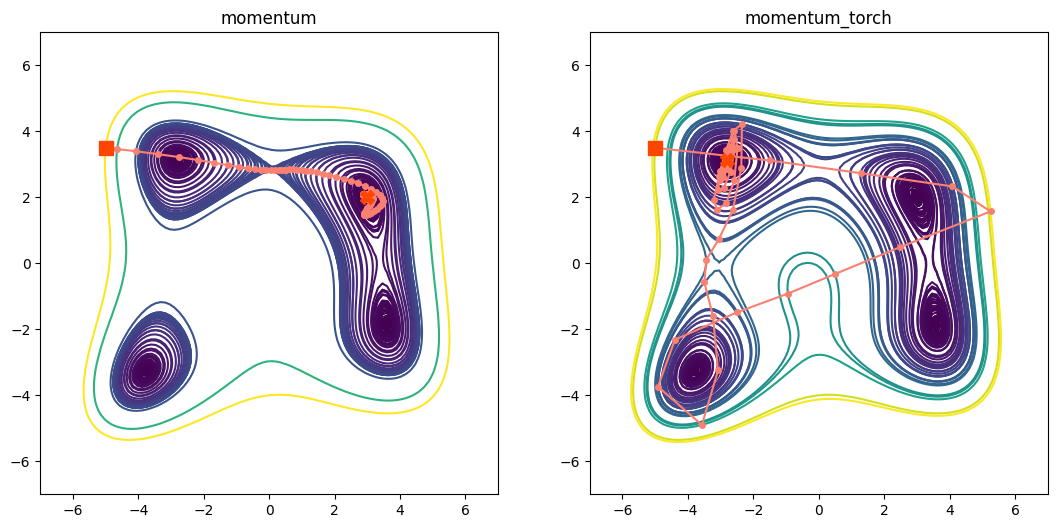

loss: 1.4248073534680265e-08, epoch: 232  gd_momentum
loss: 1.1868905858136714e-09, epoch: 245  gd_memontum_torch


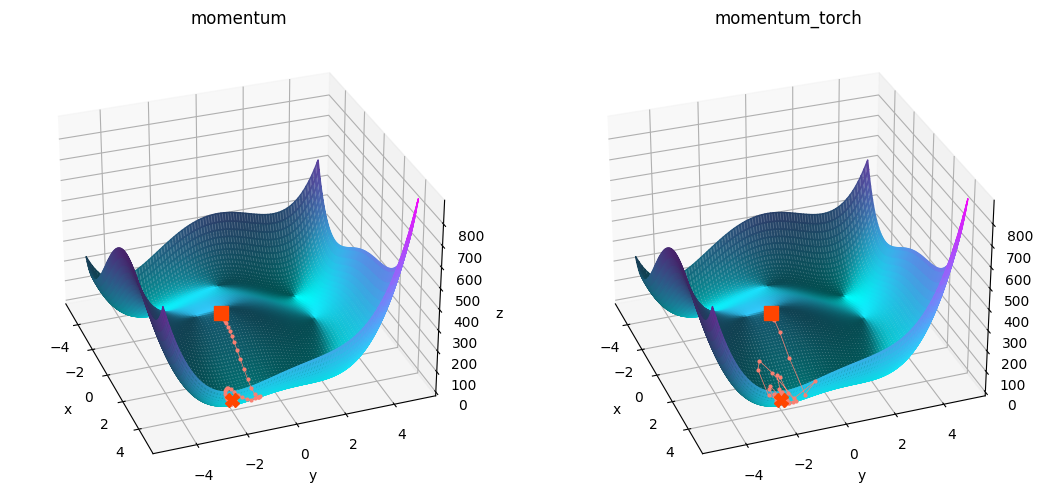

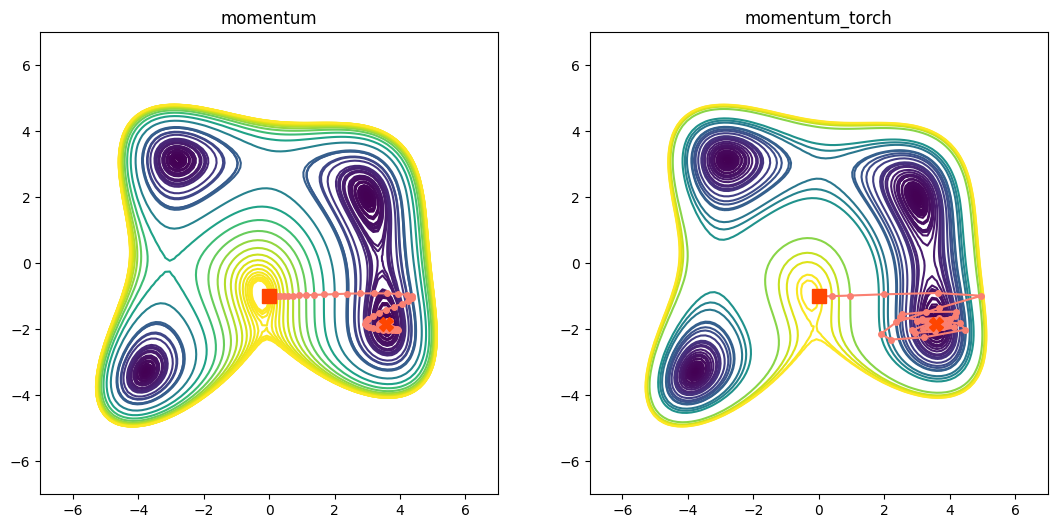

In [ ]:
def f(x, y):
    return (x ** 2 + y - 11) ** 2 + (x + y ** 2 - 7) ** 2
def grad(x, y):
    return [2 * (2 * x * (x ** 2 + y - 11) + x + y ** 2 - 7), 2 * (x ** 2 + 2 * y * (x + y ** 2 - 7) + y - 11)]

# --------------------------------------

INITIAL_THETA = [-0.005629931561978552, 0.20633830650879492]

lr = 0.01
names=["momentum", "momentum_torch"]

gd_momentum_points = gd_momentum(INITIAL_THETA, grad, f, lr=lr)
gd_momentum_torch_points = gd_momentum_torch(INITIAL_THETA, f, lr=lr)

plt.rcParams["figure.figsize"] = (13,8)
draw_3d_function_new([gd_momentum_points, gd_momentum_torch_points], -5, 5, -20, 10, 30, f, names=names)

plt.rcParams["figure.figsize"] = (13,6)
draw_lines_of_level_new([gd_momentum_points, gd_momentum_torch_points], f, names=names)

# --------------------------------------

INITIAL_THETA = [-5.0, 3.5]

lr = 0.01
names=["momentum", "momentum_torch"]

gd_momentum_points = gd_momentum(INITIAL_THETA, grad, f, lr=lr)
gd_momentum_torch_points = gd_momentum_torch(INITIAL_THETA, f, lr=lr)

plt.rcParams["figure.figsize"] = (13,8)
draw_3d_function_new([gd_momentum_points, gd_momentum_torch_points], -5, 5, -20, 10, 30, f, names=names)

plt.rcParams["figure.figsize"] = (13,6)
draw_lines_of_level_new([gd_momentum_points, gd_momentum_torch_points], f, names=names)

# --------------------------------------

INITIAL_THETA = [0.0, -1.0]

lr = 0.01
names=["momentum", "momentum_torch"]

gd_momentum_points = gd_momentum(INITIAL_THETA, grad, f, lr=lr)
gd_momentum_torch_points = gd_momentum_torch(INITIAL_THETA, f, lr=lr)

plt.rcParams["figure.figsize"] = (13,8)
draw_3d_function_new([gd_momentum_points, gd_momentum_torch_points], -5, 5, -20, 10, 30, f, names=names)

plt.rcParams["figure.figsize"] = (13,6)
draw_lines_of_level_new([gd_momentum_points, gd_momentum_torch_points], f, names=names)

## Nesterov

### torch Nesterov

In [ ]:
def gd_nesterov_torch(theta, f, lr=0.1, alpha=0.9, max_iter=1000):
  x = torch.tensor(theta[0], requires_grad=True)
  y = torch.tensor(theta[1], requires_grad=True)
  optimizer = optim.SGD([x, y], lr=lr, momentum=alpha, nesterov=True)
  points = [[x.item(), y.item()]]
  for i in range(max_iter):
      loss = f(x, y)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      points.append([x.item(), y.item()])
      if not check_points(points[-2], points[-1]):
          print(f"loss: {loss.item()}, epoch: {i}  gd_nesterov_torch")
          break
  return points

### Russian Nesterov

In [ ]:
def gd_nesterov(x, grad_f, f, lr=0.1, alpha=0.9):
    theta = x.copy()
    points = [x]
    g = np.array([0, 0], dtype=np.float64)
    epoch = 1
    while True:
        theta -= alpha * g
        g = alpha * g + (1 - alpha) * lr * np.array(grad_f(theta[0], theta[1]))
        theta = theta - g
        points.append(theta)
        if not check_points(points[-2], points[-1]):
          print(f"loss: {f(theta[0], theta[1])}, epoch: {epoch}  gd_nesterov")
          break
        epoch += 1
    return points

###comparison

loss: 2.3362961229511577e-08, epoch: 233  gd_nesterov
loss: 1.5370460459962487e-10, epoch: 67  gd_nesterov_torch


<ipython-input-115-063b2c8fcb53>:28: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = dist


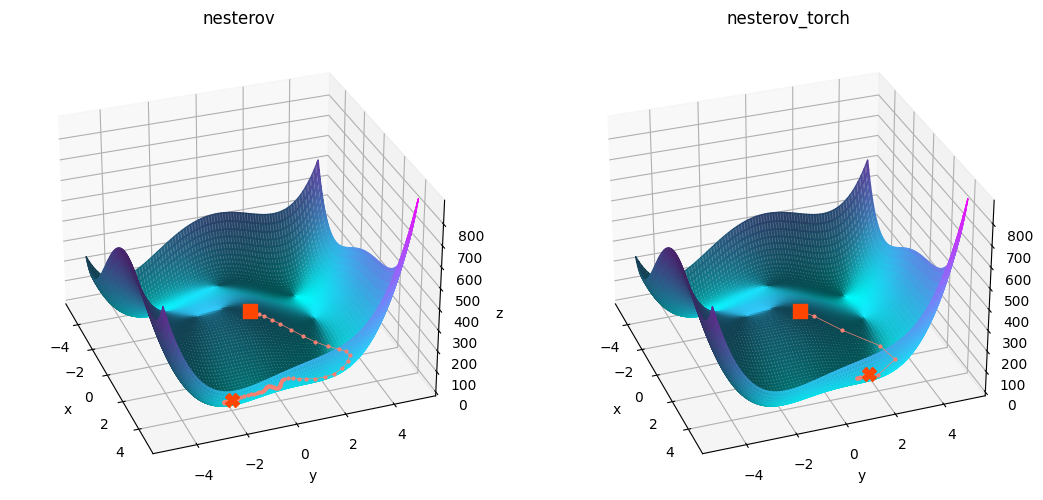

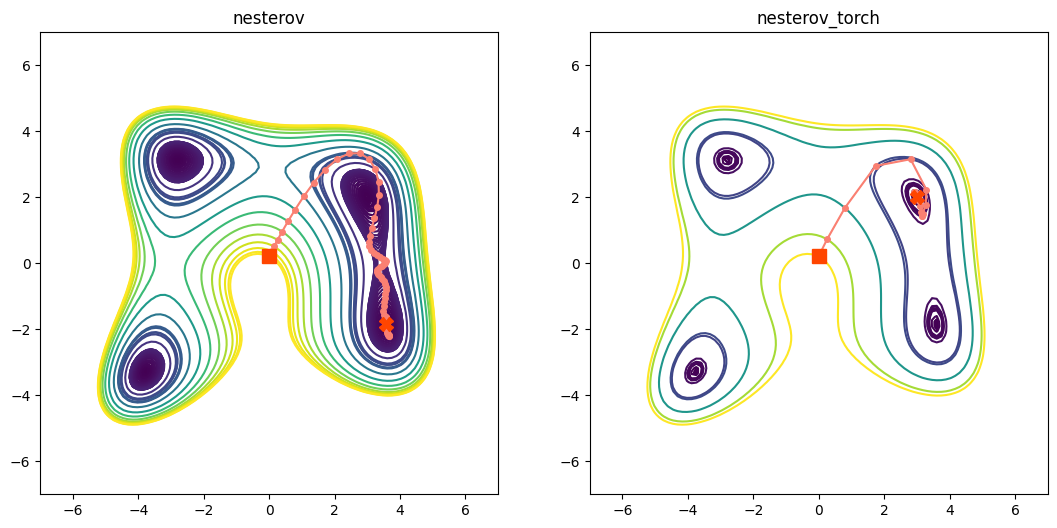

loss: 9.443286692827718e-09, epoch: 226  gd_nesterov
loss: 5.865331331733614e-09, epoch: 57  gd_nesterov_torch


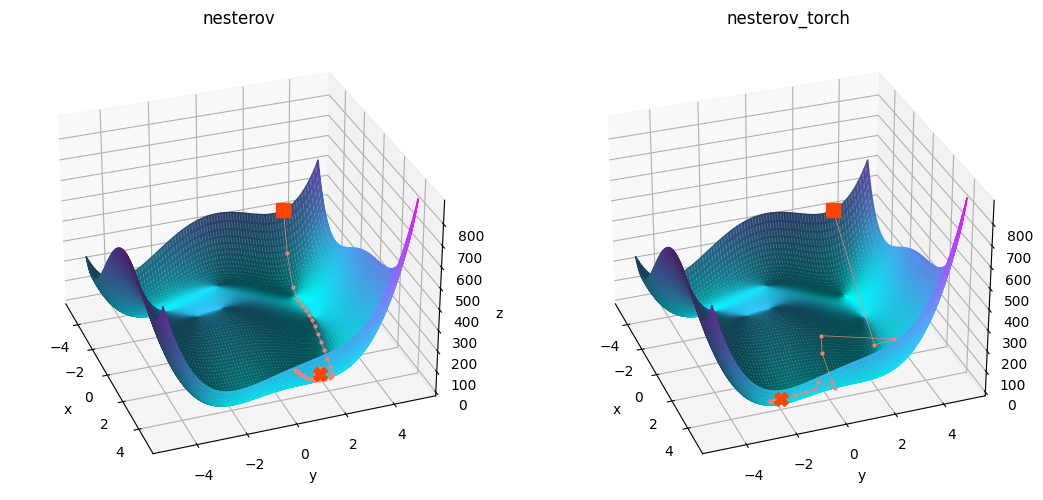

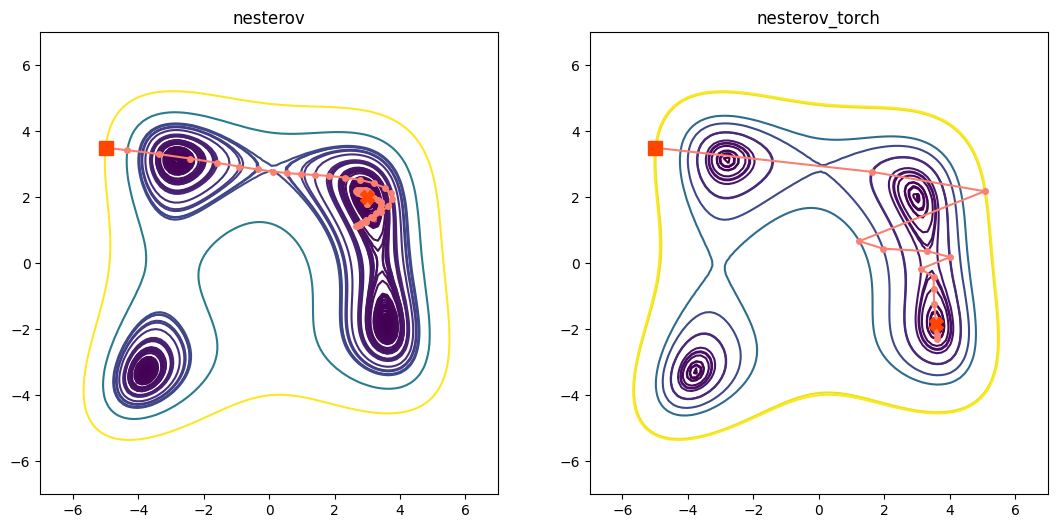

loss: 1.4547996644085699e-08, epoch: 228  gd_nesterov
loss: 3.0397586670005694e-09, epoch: 53  gd_nesterov_torch


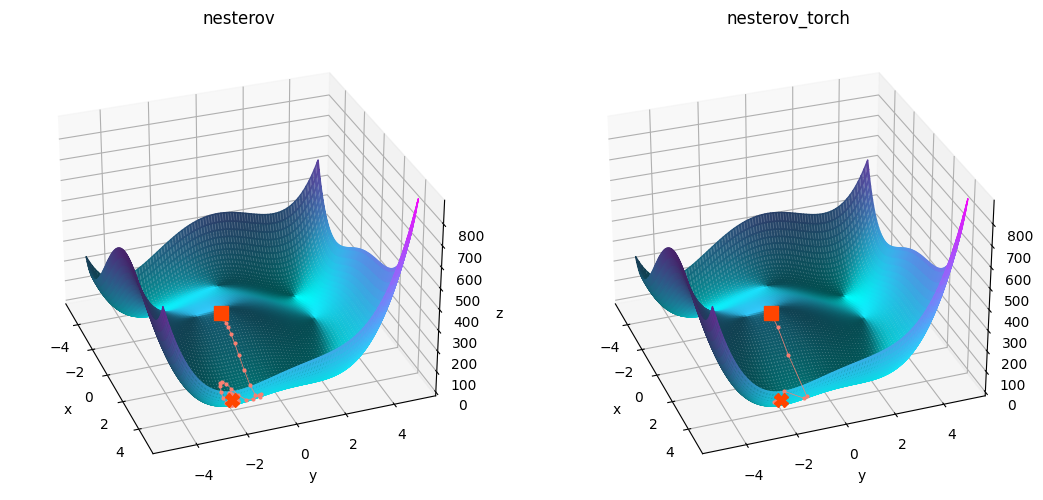

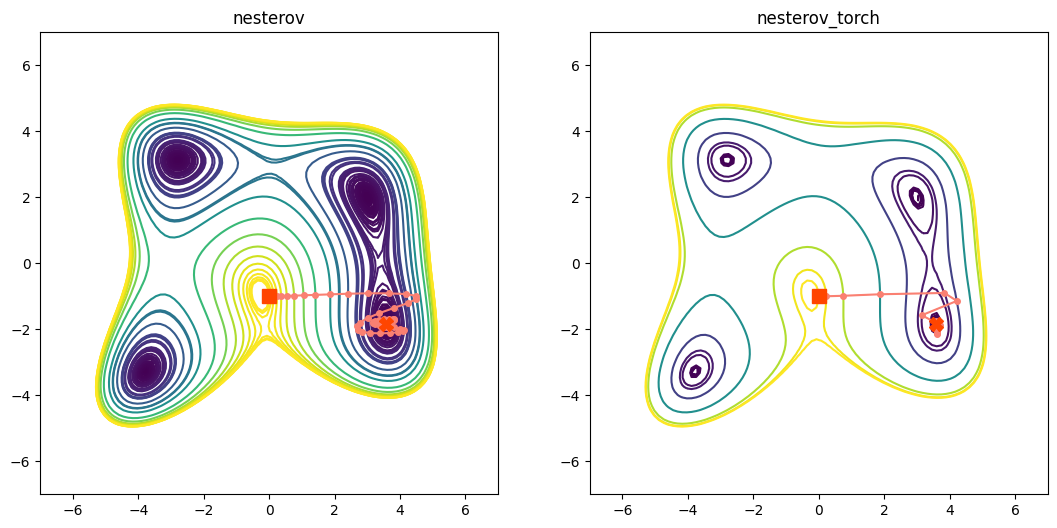

In [ ]:
def f(x, y):
    return (x ** 2 + y - 11) ** 2 + (x + y ** 2 - 7) ** 2
def grad(x, y):
    return [2 * (2 * x * (x ** 2 + y - 11) + x + y ** 2 - 7), 2 * (x ** 2 + 2 * y * (x + y ** 2 - 7) + y - 11)]

# --------------------------------------

INITIAL_THETA = [-0.005629931561978552, 0.20633830650879492]

lr = 0.01
names=["nesterov", "nesterov_torch"]

gd_nesterov_points = gd_nesterov(INITIAL_THETA, grad, f, lr=lr)
gd_nesterov_torch_points = gd_nesterov_torch(INITIAL_THETA, f, lr=lr)

plt.rcParams["figure.figsize"] = (13,8)
draw_3d_function_new([gd_nesterov_points, gd_nesterov_torch_points], -5, 5, -20, 10, 30, f, names=names)

plt.rcParams["figure.figsize"] = (13,6)
draw_lines_of_level_new([gd_nesterov_points, gd_nesterov_torch_points], f, names=names)

# --------------------------------------

INITIAL_THETA = [-5.0, 3.5]

lr = 0.01
names=["nesterov", "nesterov_torch"]

gd_nesterov_points = gd_nesterov(INITIAL_THETA, grad, f, lr=lr)
gd_nesterov_torch_points = gd_nesterov_torch(INITIAL_THETA, f, lr=lr)

plt.rcParams["figure.figsize"] = (13,8)
draw_3d_function_new([gd_nesterov_points, gd_nesterov_torch_points], -5, 5, -20, 10, 30, f, names=names)

plt.rcParams["figure.figsize"] = (13,6)
draw_lines_of_level_new([gd_nesterov_points, gd_nesterov_torch_points], f, names=names)

# --------------------------------------

INITIAL_THETA = [0.0, -1.0]

lr = 0.01
names=["nesterov", "nesterov_torch"]

gd_nesterov_points = gd_nesterov(INITIAL_THETA, grad, f, lr=lr)
gd_nesterov_torch_points = gd_nesterov_torch(INITIAL_THETA, f, lr=lr)

plt.rcParams["figure.figsize"] = (13,8)
draw_3d_function_new([gd_nesterov_points, gd_nesterov_torch_points], -5, 5, -20, 10, 30, f, names=names)

plt.rcParams["figure.figsize"] = (13,6)
draw_lines_of_level_new([gd_nesterov_points, gd_nesterov_torch_points], f, names=names)

## AdaGrad

### torch AdaGrad

In [ ]:
def gd_adagrad_torch(theta, f, lr=0.1, eps=1e-6, max_iter=1000):
  x = torch.tensor(theta[0], requires_grad=True)
  y = torch.tensor(theta[1], requires_grad=True)
  optimizer = optim.Adagrad([x, y], lr=lr, eps=eps)
  points = [[x.item(), y.item()]]
  for i in range(max_iter):
      loss = f(x, y)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      points.append([x.item(), y.item()])
      if not check_points(points[-2], points[-1]):
          print(f"loss: {loss.item()}, epoch: {i}  gd_adagrad_torch")
          break
  return points

### Russian AdaGrad

In [ ]:
def gd_adagrad(x, grad_f, f, lr=0.1):
    theta = x.copy()
    points = [x]
    g = np.array([0, 0], dtype=np.float64)
    epoch = 1
    while True:
        grad = np.array(grad_f(theta[0], theta[1]))
        g += grad ** 2
        theta = theta - lr / (g ** 0.5) * grad
        points.append(theta)
        if not check_points(points[-2], points[-1]):
            print(f"loss: {f(theta[0], theta[1])}, epoch: {epoch}  gd_adagrad")
            break
        epoch += 1
    return points

### comparison

loss: 4.5940981101804773e-10, epoch: 79  gd_adagrad
loss: 6.120899342931807e-10, epoch: 78  gd_adagrad_torch


<ipython-input-115-063b2c8fcb53>:28: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = dist


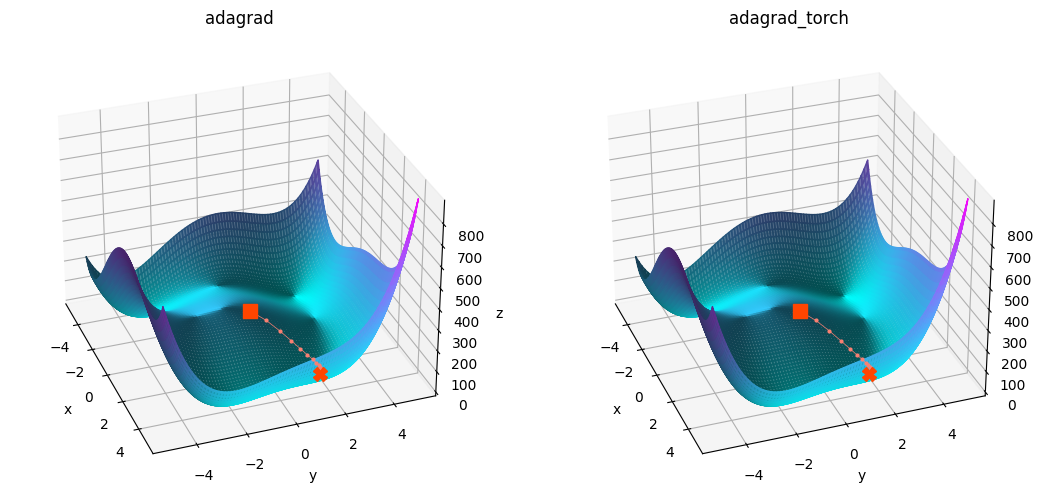

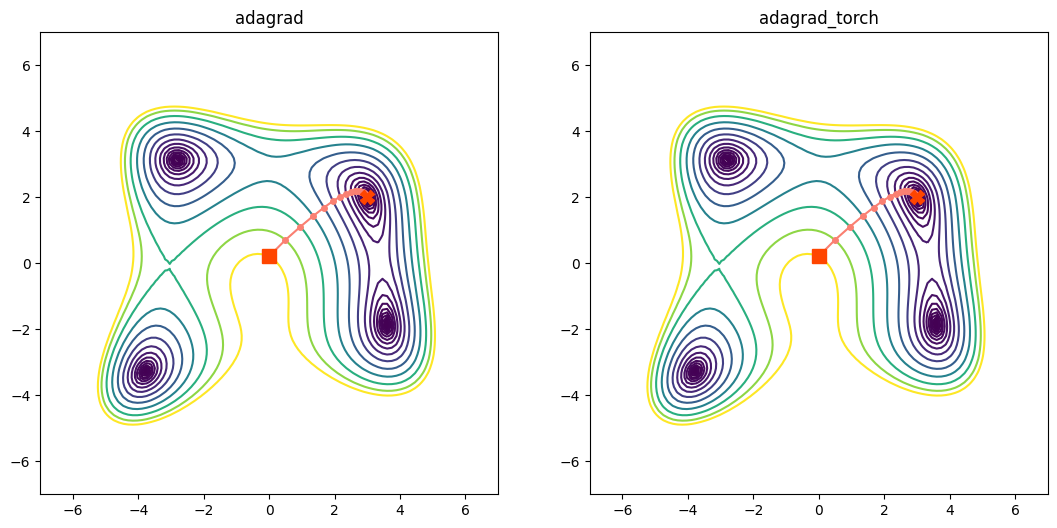

loss: 7.583610112492108e-09, epoch: 172  gd_adagrad
loss: 9.695213520899415e-09, epoch: 170  gd_adagrad_torch


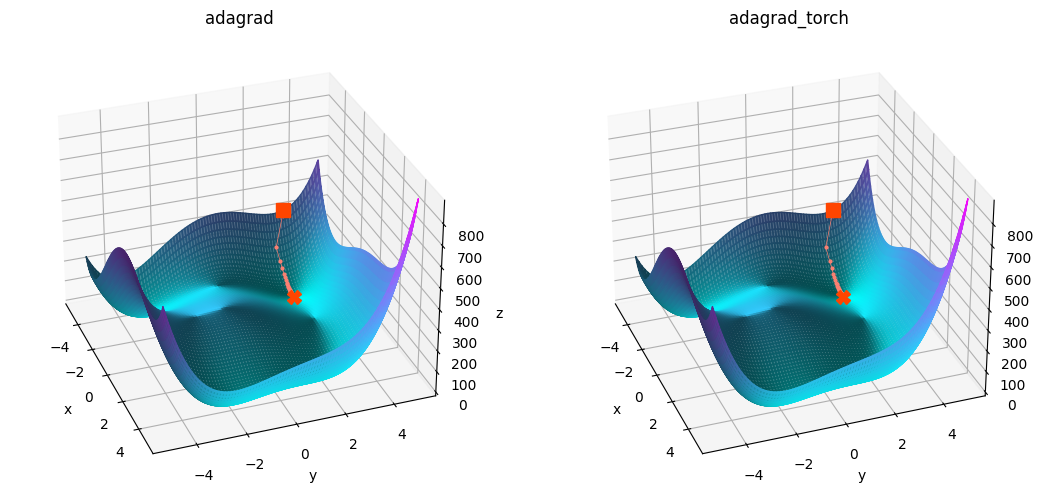

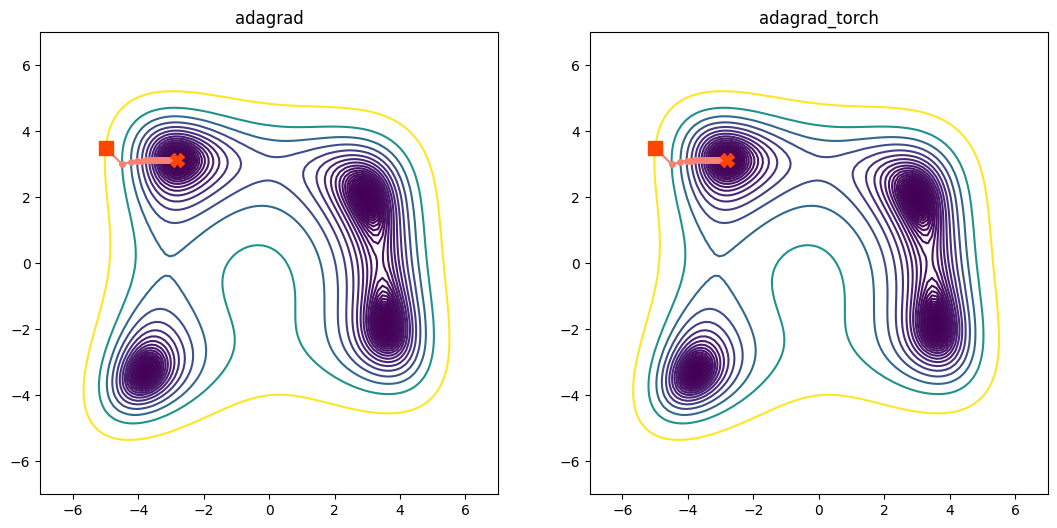

In [ ]:
def f(x, y):
    return (x ** 2 + y - 11) ** 2 + (x + y ** 2 - 7) ** 2
def grad(x, y):
    return [2 * (2 * x * (x ** 2 + y - 11) + x + y ** 2 - 7), 2 * (x ** 2 + 2 * y * (x + y ** 2 - 7) + y - 11)]

# --------------------------------------

INITIAL_THETA = [-0.005629931561978552, 0.20633830650879492]

lr = 0.5
names = ["adagrad", "adagrad_torch"]

gd_adagrad_points = gd_adagrad(INITIAL_THETA, grad, f, lr=lr)
gd_adagrad_torch_points = gd_adagrad_torch(INITIAL_THETA, f, lr=lr)

plt.rcParams["figure.figsize"] = (13,8)
draw_3d_function_new([gd_adagrad_points, gd_adagrad_torch_points], -5, 5, -20, 10, 30, f, names=names)

plt.rcParams["figure.figsize"] = (13,6)
draw_lines_of_level_new([gd_adagrad_points, gd_adagrad_torch_points], f, names=names)

# --------------------------------------

INITIAL_THETA = [-5.0, 3.5]

lr = 0.5
names = ["adagrad", "adagrad_torch"]

gd_adagrad_points = gd_adagrad(INITIAL_THETA, grad, f, lr=lr)
gd_adagrad_torch_points = gd_adagrad_torch(INITIAL_THETA, f, lr=lr)

plt.rcParams["figure.figsize"] = (13,8)
draw_3d_function_new([gd_adagrad_points, gd_adagrad_torch_points], -5, 5, -20, 10, 30, f, names=names)

plt.rcParams["figure.figsize"] = (13,6)
draw_lines_of_level_new([gd_adagrad_points, gd_adagrad_torch_points], f, names=names)

# --------------------------------------


## RMSProp

### torch RMSProp

In [ ]:
def gd_rmsprop_torch(theta, f, lr=0.1, eps=1e-6, alpha=0.9, max_iter=1000):
  x = torch.tensor(theta[0], requires_grad=True)
  y = torch.tensor(theta[1], requires_grad=True)
  optimizer = optim.RMSprop([x, y], lr=lr, alpha=alpha, eps=eps)
  points = [[x.item(), y.item()]]
  for i in range(max_iter):
      loss = f(x, y)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      points.append([x.item(), y.item()])
      if not check_points(points[-2], points[-1]):
          print(f"loss: {loss.item()}, epoch: {i}  gd_rmsprop_torch")
          break
  return points

### Russian RMSProp

In [ ]:
def gd_rmsprop(x, grad_f, f, lr=2, gamma=0.9):
    theta = x.copy()
    points = [x]
    g = np.array([0, 0], dtype=np.float64)
    epoch = 1
    while True:
        grad = np.array(grad_f(theta[0], theta[1]))
        g = gamma * g + (1 - gamma) * grad ** 2
        theta = theta - lr / (g ** 0.5 + 1e-6) * grad
        points.append(theta)
        if len(points) > 2 and (points[-1] == points[-3]).all():
          break
        if not check_points(points[-2], points[-1]):
          break
        epoch += 1
    print(f"loss: {f(theta[0], theta[1])}, epoch: {epoch}  gd_rmsprop")
    return points

### comparison

loss: 5.284307380553349e-12, epoch: 50  gd_rmsprop
loss: 5.6843418860808015e-12, epoch: 50  gd_rmsprop_torch


<ipython-input-115-063b2c8fcb53>:28: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = dist


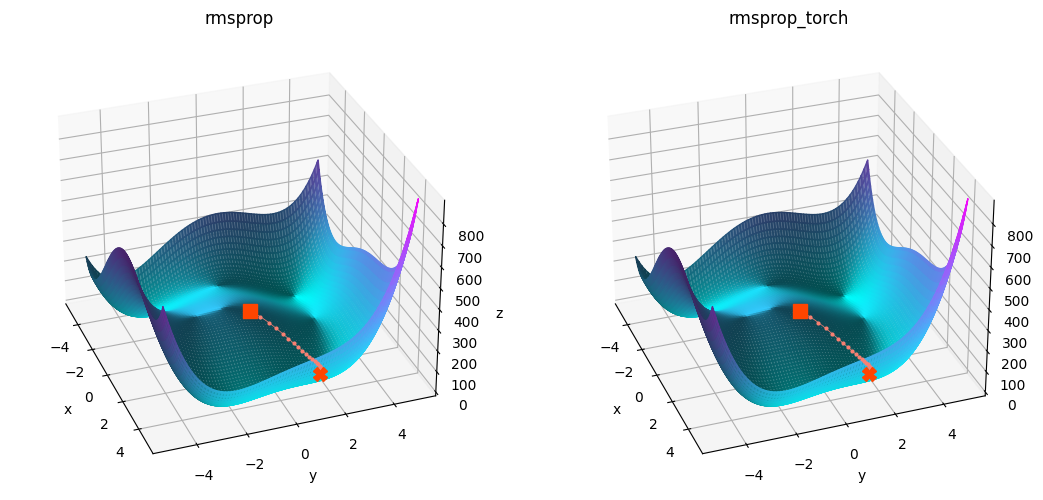

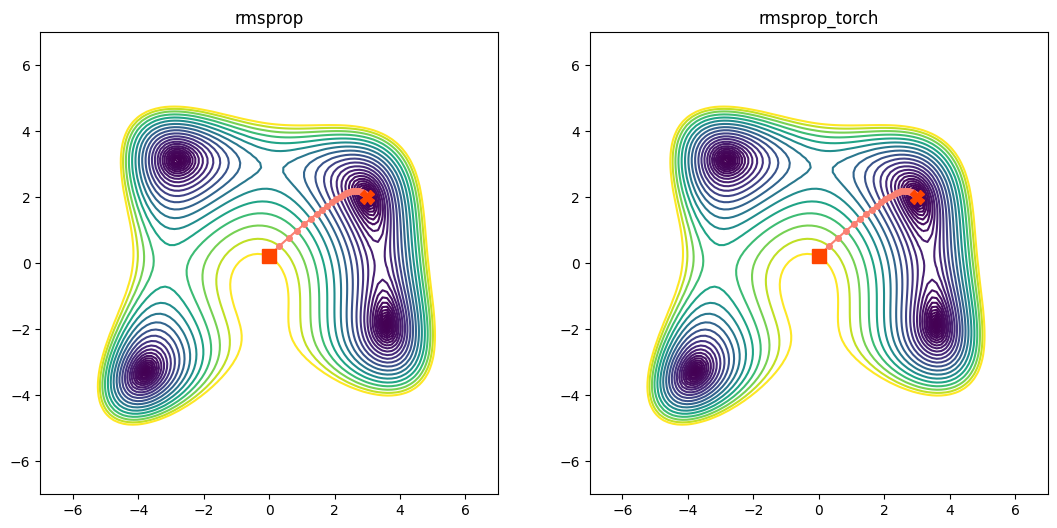

loss: 0.186225813977188, epoch: 637  gd_rmsprop


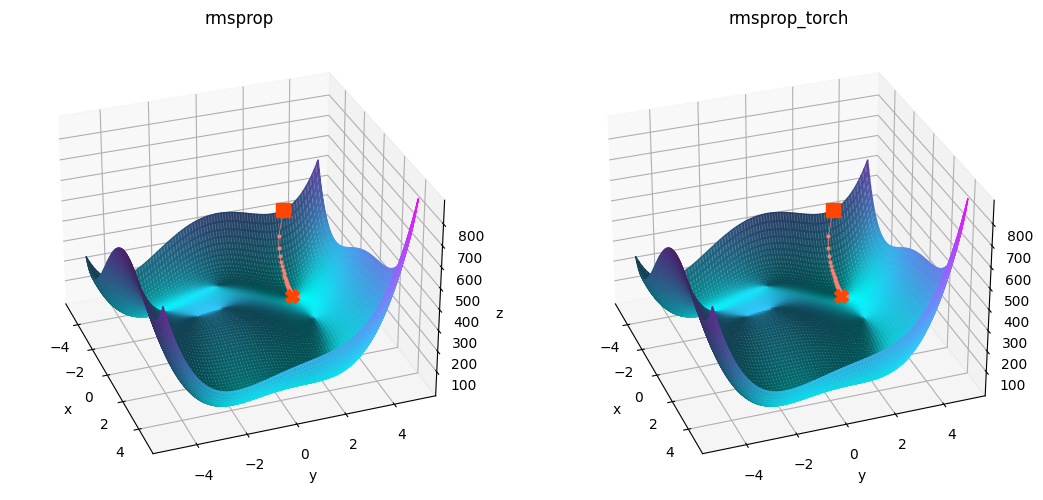

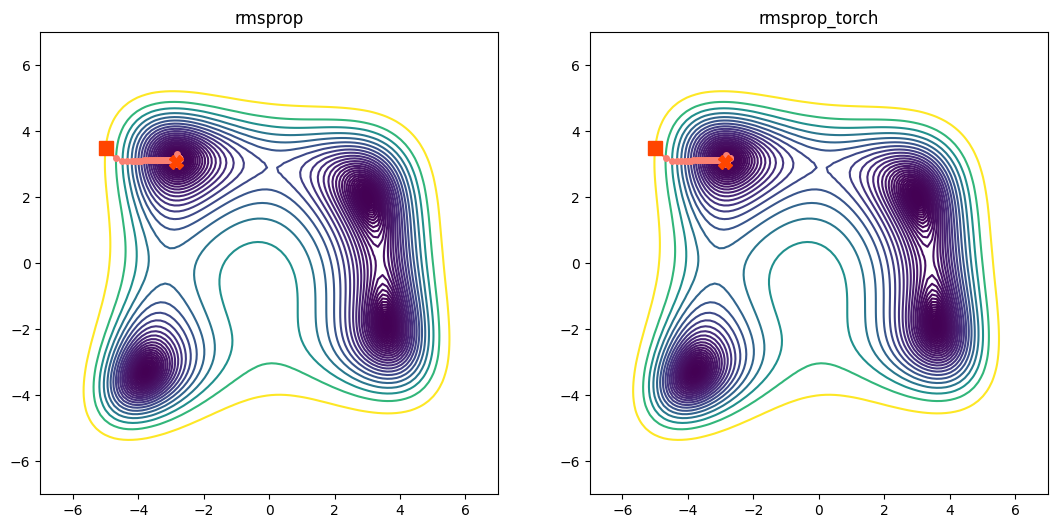

loss: 1.9926444202247695e-12, epoch: 51  gd_rmsprop
loss: 1.4779288903810084e-11, epoch: 50  gd_rmsprop_torch


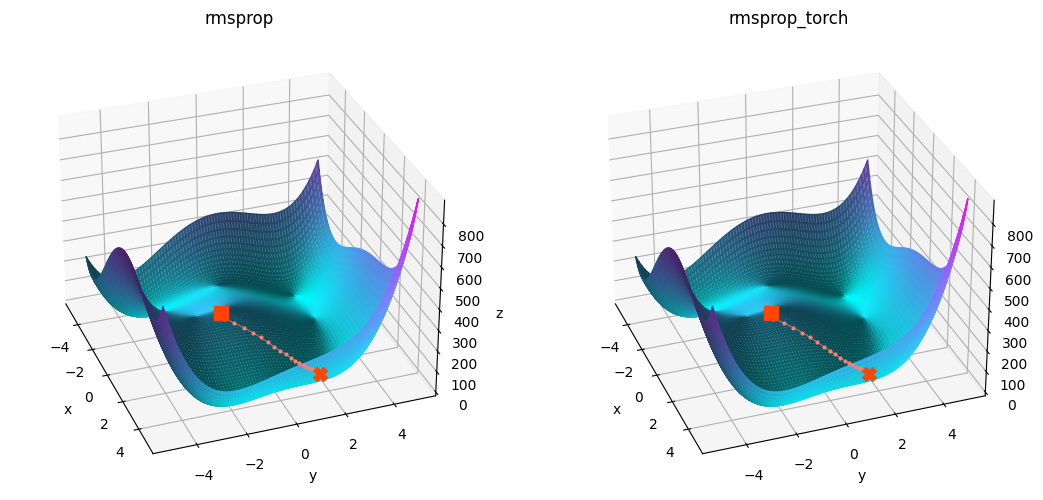

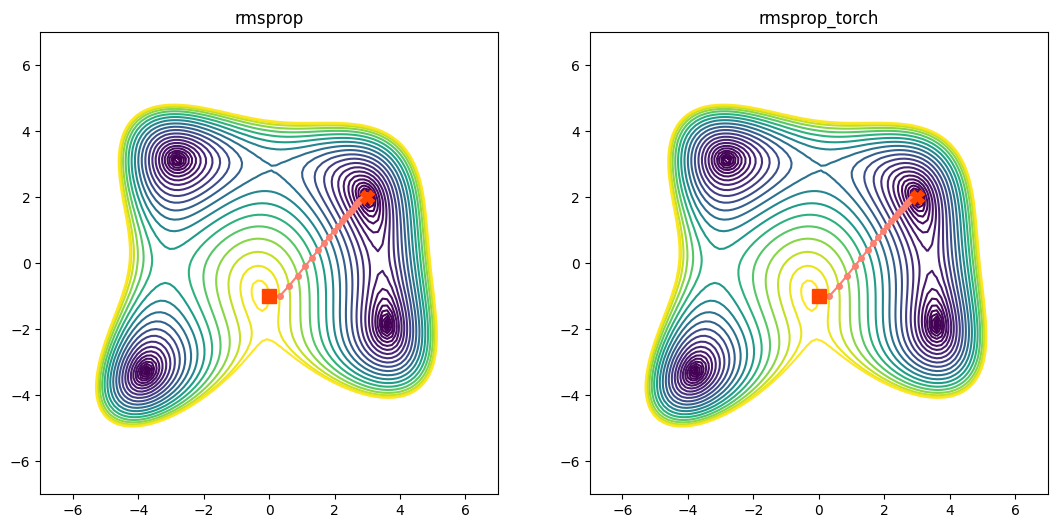

In [ ]:
def f(x, y):
    return (x ** 2 + y - 11) ** 2 + (x + y ** 2 - 7) ** 2
def grad(x, y):
    return [2 * (2 * x * (x ** 2 + y - 11) + x + y ** 2 - 7), 2 * (x ** 2 + 2 * y * (x + y ** 2 - 7) + y - 11)]

# --------------------------------------

INITIAL_THETA = [-0.005629931561978552, 0.20633830650879492]

lr = 0.1
names = ["rmsprop", "rmsprop_torch"]

gd_rmsprop_points = gd_rmsprop(INITIAL_THETA, grad, f, lr=lr)
gd_rmsprop_torch_points = gd_rmsprop_torch(INITIAL_THETA, f, lr=lr)

plt.rcParams["figure.figsize"] = (13,8)
draw_3d_function_new([gd_rmsprop_points, gd_rmsprop_torch_points], -5, 5, -20, 10, 30, f, names=names)

plt.rcParams["figure.figsize"] = (13,6)
draw_lines_of_level_new([gd_rmsprop_points, gd_rmsprop_torch_points], f, names=names)

# --------------------------------------

INITIAL_THETA = [-5.0, 3.5]

lr = 0.1
names = ["rmsprop", "rmsprop_torch"]

gd_rmsprop_points = gd_rmsprop(INITIAL_THETA, grad, f, lr=lr)
gd_rmsprop_torch_points = gd_rmsprop_torch(INITIAL_THETA, f, lr=lr)

plt.rcParams["figure.figsize"] = (13,8)
draw_3d_function_new([gd_rmsprop_points, gd_rmsprop_torch_points], -5, 5, -20, 10, 30, f, names=names)

plt.rcParams["figure.figsize"] = (13,6)
draw_lines_of_level_new([gd_rmsprop_points, gd_rmsprop_torch_points], f, names=names)

# --------------------------------------

INITIAL_THETA = [0.0, -1.0]

lr = 0.1
names = ["rmsprop", "rmsprop_torch"]

gd_rmsprop_points = gd_rmsprop(INITIAL_THETA, grad, f, lr=lr)
gd_rmsprop_torch_points = gd_rmsprop_torch(INITIAL_THETA, f, lr=lr)

plt.rcParams["figure.figsize"] = (13,8)
draw_3d_function_new([gd_rmsprop_points, gd_rmsprop_torch_points], -5, 5, -20, 10, 30, f, names=names)

plt.rcParams["figure.figsize"] = (13,6)
draw_lines_of_level_new([gd_rmsprop_points, gd_rmsprop_torch_points], f, names=names)

## Adam

### torch Adam

In [ ]:
def gd_adam_torch(theta, f, lr=0.1, eps=1e-6, betas=(0.9, 0.999), max_iter=1000):
  x = torch.tensor(theta[0], requires_grad=True)
  y = torch.tensor(theta[1], requires_grad=True)
  optimizer = optim.Adam([x, y], lr=lr, betas=betas, eps=eps)
  points = [[x.item(), y.item()]]
  for i in range(max_iter):
      loss = f(x, y)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      points.append([x.item(), y.item()])
      if not check_points(points[-2], points[-1]):
          print(f"loss: {loss.item()}, epoch: {i}  gd_adam_torch")
          break
  return points

### Russian Adam

In [ ]:
def gd_adam(x, grad_f, f, lr=0.1, b1=0.9, b2=0.999):
    theta = x.copy()
    points = [x]
    m = np.array([0, 0], dtype=np.float64)
    v = np.array([0, 0], dtype=np.float64)
    epoch = 1
    while True:
        grad = np.array(grad_f(theta[0], theta[1]))
        m = b1 * m + (1 - b1) * grad
        v = b2 * v + (1 - b2) * grad ** 2
        mm = m / (1 - b1 ** epoch)
        vv = v / (1 - b2 ** epoch)
        theta = theta - lr / (vv ** 0.5) * mm
        points.append(theta)
        if not check_points(points[-2], points[-1]):
          print(f"loss: {f(theta[0], theta[1])}, epoch: {epoch}  gd_adam")
          break
        epoch += 1
    return points

### comparison

loss: 2.1421823082777594e-09, epoch: 244  gd_adam
loss: 1.4915713109076023e-09, epoch: 243  gd_adam_torch


<ipython-input-115-063b2c8fcb53>:28: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = dist


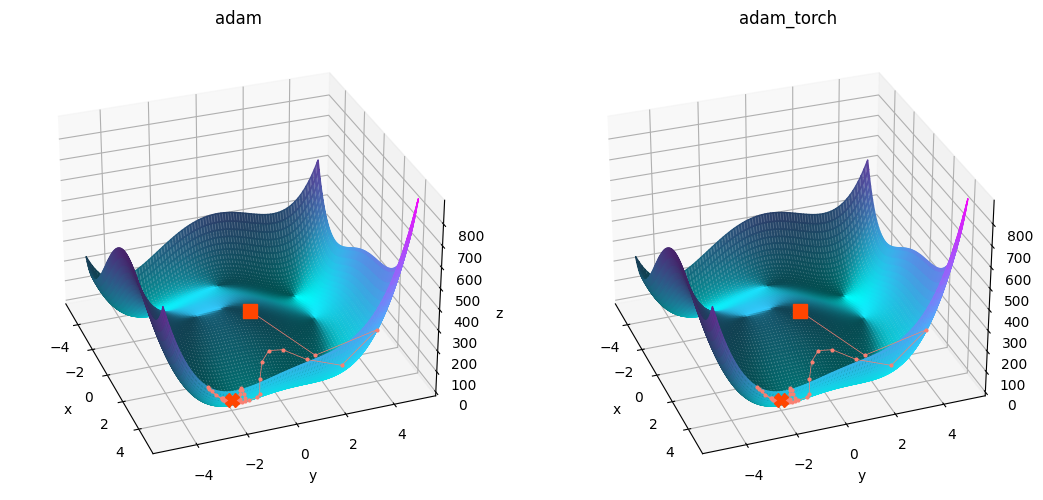

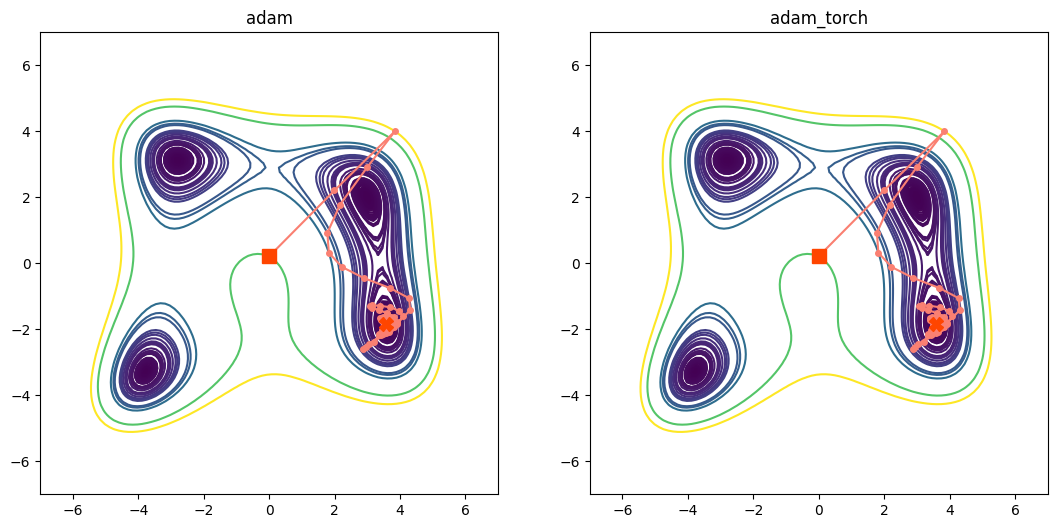

loss: 4.777401430835469e-10, epoch: 261  gd_adam
loss: 7.439932687702822e-07, epoch: 189  gd_adam_torch


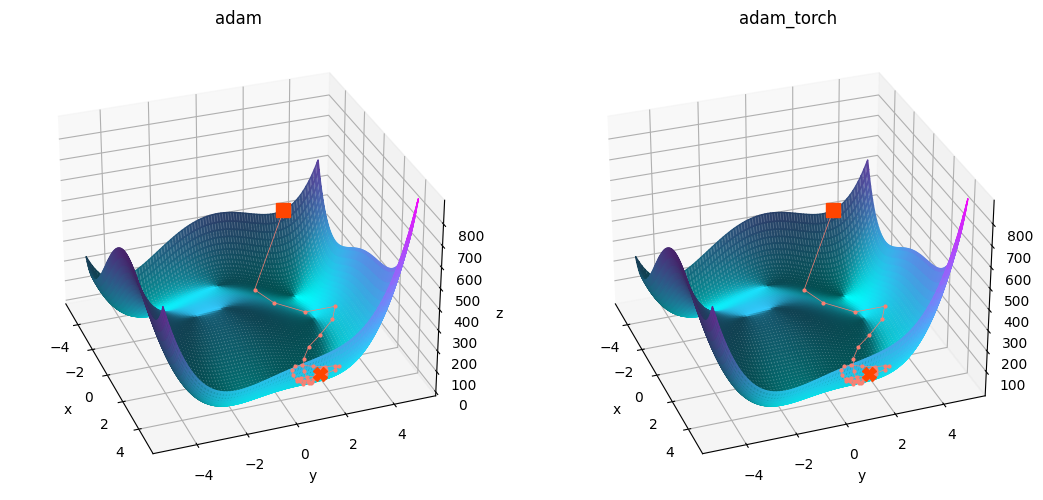

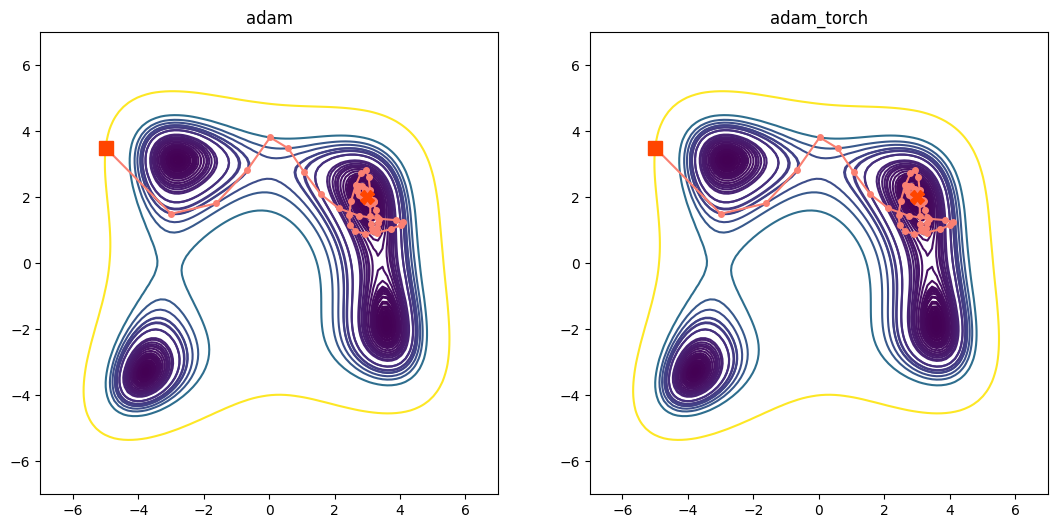

In [ ]:
def f(x, y):
    return (x ** 2 + y - 11) ** 2 + (x + y ** 2 - 7) ** 2
def grad(x, y):
    return [2 * (2 * x * (x ** 2 + y - 11) + x + y ** 2 - 7), 2 * (x ** 2 + 2 * y * (x + y ** 2 - 7) + y - 11)]

# --------------------------------------

INITIAL_THETA = [-0.005629931561978552, 0.20633830650879492]

lr = 2
names = ["adam", "adam_torch"]

gd_adam_points = gd_adam(INITIAL_THETA, grad, f, lr=lr)
gd_adam_torch_points = gd_adam_torch(INITIAL_THETA, f, lr=lr)

plt.rcParams["figure.figsize"] = (13,8)
draw_3d_function_new([gd_adam_points, gd_adam_torch_points], -5, 5, -20, 10, 30, f, names=names)

plt.rcParams["figure.figsize"] = (13,6)
draw_lines_of_level_new([gd_adam_points, gd_adam_torch_points], f, names=names)

# --------------------------------------

INITIAL_THETA = [-5.0, 3.5]

lr = 2
names = ["adam", "adam_torch"]

gd_adam_points = gd_adam(INITIAL_THETA, grad, f, lr=lr)
gd_adam_torch_points = gd_adam_torch(INITIAL_THETA, f, lr=lr)

plt.rcParams["figure.figsize"] = (13,8)
draw_3d_function_new([gd_adam_points, gd_adam_torch_points], -5, 5, -20, 10, 30, f, names=names)

plt.rcParams["figure.figsize"] = (13,6)
draw_lines_of_level_new([gd_adam_points, gd_adam_torch_points], f, names=names)

# --------------------------------------

# 2 пункт

In [ ]:
def loss_function(Y, X, theta, func):
    sum = 0
    for i in range(len(Y)):
      sum += (Y[i] - func(theta, X[i]))**2
    return sum

## Gauss-Newton

### scipy Newton

In [33]:
def scipy_newton(theta, func, gradient, hess):
  parameters = theta.copy()
  result = opt.minimize(func, parameters, method='Newton-CG', jac=gradient, hess=hess)
  print(f"loss: {func(result.x)}, epoch: {result.nit}  scipy_newton")
  snap = tracemalloc.take_snapshot()
  return {'th' : func(result.x), 'iter' : result.nit, 'snap' : snap}

### Ahuenii Newton 

In [34]:
def gauss_newton(X, Y, coefficients, loss_function, func, eps=1e-4):
    theta = np.array(coefficients.copy(), dtype=np.float64)
    previous_cost = 10 ** 6
    current_cost = loss_function(Y, X, theta, func)
    epoch = 1
    while np.abs(previous_cost - current_cost) > eps:
        previous_cost = current_cost
        loss = np.array([0 for i in range(len(Y))], dtype=np.float64)
        for i in range(len(loss)):
          loss[i] = func(theta, X[i]) - Y[i]
        jacobian = []
        for i, parameter in enumerate(theta):
            x = theta.copy()
            x[i] += eps
            new_loss = np.array([0 for i in range(len(Y))], dtype=np.float64)
            for i in range(len(loss)):
              new_loss[i] = func(x, X[i]) - Y[i]
            derivative = (new_loss - loss) / eps
            jacobian.append(derivative)
        jacobian = np.array(jacobian, dtype=np.float64).T
        theta = theta - np.linalg.pinv(jacobian.T @ jacobian) @ jacobian.T @ loss
        current_cost = loss_function(Y, X, theta, func)
        epoch += 1
    print(f"loss: {current_cost}, epoch: {epoch-1}     newton")
    snap = tracemalloc.take_snapshot() 
    return {'th' : current_cost, 'iter' : epoch, 'snap' : snap}

### тут насрано (comparison)

initial: [1, 1, 1, 1]
loss: 49.4987973651773, epoch: 2     newton
loss: 49.49879736517727, epoch: 6  scipy_newton


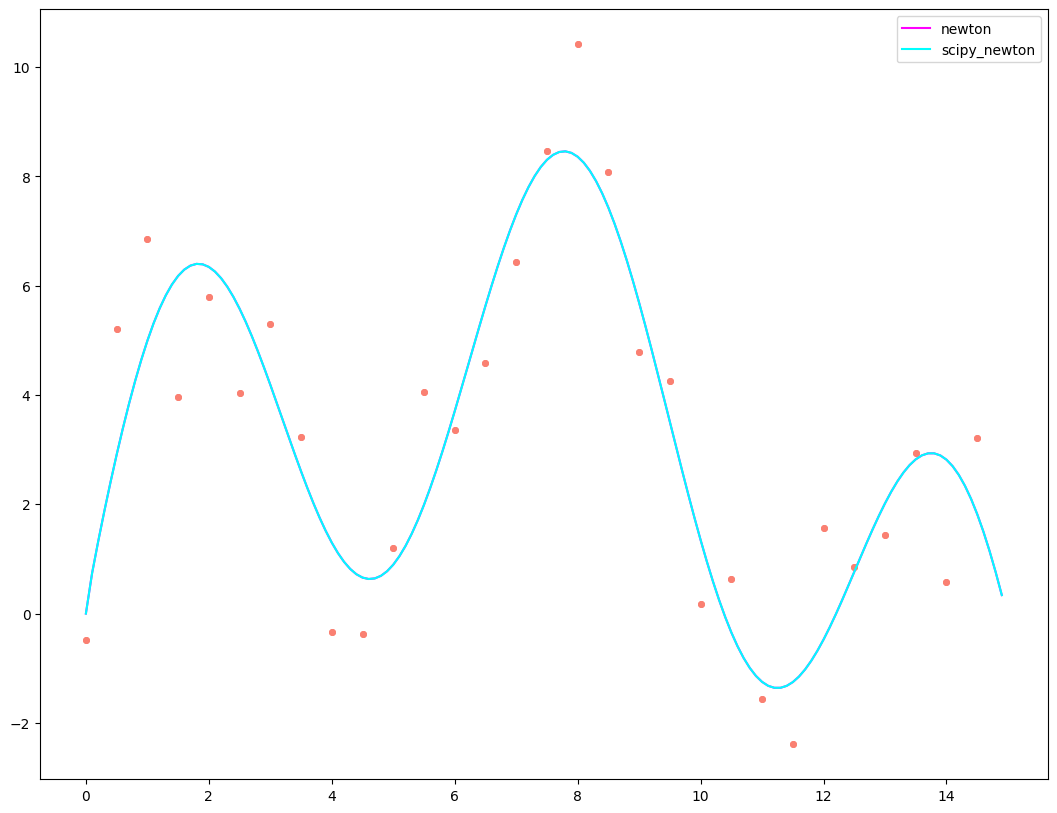

initial: [-20, -20, -20, -20]
loss: 49.4987973651773, epoch: 2     newton
loss: 49.498797365177275, epoch: 9  scipy_newton
initial: [100, 100, 100, 100]
loss: 49.4987973651773, epoch: 2     newton
loss: 49.498797365177275, epoch: 9  scipy_newton


array([ 3.87938321,  0.76295019, -0.09543995,  1.05886405])

In [35]:
TOTAL = 30
STEP = 0.5
FROM = 0
INITIAL_THETA = [1, 1, 1, 1]
lr = 1
eps = 1e-6

def mysin(x):
    return sp.sin(x)

def mysqrt(x):
    return sp.sqrt(x)

X_new = np.arange(0, 15, 0.1, dtype=np.float64)


symbols = sp.symbols(f"x:{len(INITIAL_THETA)}")
x = sp.symbols("x")
y = sp.symbols("y")

def function1(x):
  return 4 * sp.sin(x) + x ** 0.5 - 0.1 * x ** 2 + 1 * x

func1 = symbols[0] * sp.sin(x) + symbols[1] * sp.sqrt(x) + symbols[2] * x ** 2 + symbols[3] * x 


func = sp.lambdify([symbols, x], func1, {"sin":mysin, "sqrt":mysqrt})

loss_func = (y - func(symbols, x)) ** 2
loss_function_grad = [sp.diff(loss_func, symbol) for symbol in symbols]
loss_function_grad = [sp.lambdify([symbols, y, x], grad, 'numpy') for grad in loss_function_grad]

hessian = [[sp.diff(sp.diff(loss_func, a), b) for a in symbols] for b in symbols]
hessian_func = [[i for i in range(len(hessian))] for _ in range(len(hessian[0]))]
for i in range(len(hessian)):
  for j in range(len(hessian[i])):
    hessian_func[i][j] = sp.lambdify([symbols, y, x], hessian[i][j], 'numpy')

X = np.arange(FROM, TOTAL * STEP + FROM, STEP, dtype=np.float64)
Y = np.array([function1(x1) + np.random.uniform(-1, 1) * np.random.uniform(1, 3) for x1 in X], dtype=np.float64)

def error_func(params):
    sum = 0
    for i in range(len(Y)):
      sum += (Y[i] - (params[0] * np.sin(X[i]) + params[1] * np.sqrt(X[i]) + params[2] * X[i] ** 2 + params[3] * X[i])) ** 2
    return sum

def grad_for_scp(Y, X, theta, loss_function_grad):
    grad = [0 for _ in range(len(theta))]
    for i in range(len(theta)):
      for k in range(len(Y)):
          grad[i] += loss_function_grad[i](theta, Y[k], X[k])
    return grad

def hess_for_scp(Y, X, theta, hess_function):
    hes = [[0 for _ in range(len(theta))] for _ in range(len(theta))]
    for i in range(len(theta)):
      for j in range(len(theta)):
         for k in range(len(Y)):
            hes[i][j] += hess_function[i][j](theta, Y[k], X[k])
    return hes

def loss_function(Y, X, theta, func):
    sum = 0
    for i in range(len(Y)):
      sum += (Y[i] - func(theta, X[i]))**2
    return sum

jac = sp.lambdify([symbols], grad_for_scp(Y, X, symbols, loss_function_grad), 'numpy')
hess = sp.lambdify([symbols], hess_for_scp(Y, X, symbols, hessian_func), 'numpy')

# ------------------------------------------------

print("initial:", INITIAL_THETA)
result = [0, 0]

result[0] = gauss_newton(X, Y, INITIAL_THETA, loss_function, func, eps=eps)
result[1] = scipy_newton(INITIAL_THETA, error_func, jac, hess)

colors = ['fuchsia', 'aqua']
labels = ['newton', 'scipy_newton']

plt.rcParams["figure.figsize"] = (13, 10)

fig, ax = plt.subplots()
for i in range(len(result)):
  ax.plot(X, Y, 'o', color='salmon', zorder=4, markersize=4)
  ax.plot(X_new, [func(result[i], p) for p in X_new], '-', color=colors[i], zorder=4, markersize=4, label=labels[i])
ax.legend()
plt.show()

# ------------------------------------------------

INITIAL_THETA = [-20, -20, -20, -20]

print("initial:", INITIAL_THETA)

gauss_newton(X, Y, INITIAL_THETA, loss_function, func, eps=eps)
scipy_newton(INITIAL_THETA, error_func, jac, hess)

# ------------------------------------------------

INITIAL_THETA = [100, 100, 100, 100]

print("initial:", INITIAL_THETA)

gauss_newton(X, Y, INITIAL_THETA, loss_function, func, eps=eps)
scipy_newton(INITIAL_THETA, error_func, jac, hess)

In [36]:
data_second_task

Cost (lower is better)  Iterations  Time (sec)  \
gauss_newton             40.6815406058109         3.0       0.460   
scipy_newton                    40.681541         6.0       0.006   
gauss_newton_th-20       40.6815406058109         3.0       0.441   
scipy_newton_th-20              40.681541         9.0       0.012   
gauss_newton_th100       40.6815406058109         3.0       0.432   
scipy_newton_th100              40.681541         9.0       0.009   

                    Memory (KiB)  
gauss_newton          513.369141  
scipy_newton           28.208008  
gauss_newton_th-20    497.518555  
scipy_newton_th-20     26.282227  
gauss_newton_th100    510.320312  
scipy_newton_th100     26.494141

## DogLeg

### scipy DogLeg

In [25]:
def scipy_dogleg(theta, func, gradient, hess):
  parameters = theta.copy()
  result = opt.minimize(func, parameters, method='dogleg', jac=gradient, hess=hess)
  print(f"loss: {func(result.x)}, epoch: {result.nit}  scipy_dogleg")

  snap = tracemalloc.take_snapshot()
  return {'th' : func(result.x), 'iter' : result.nit, 'snap' : snap}

### Russian DogLeg

In [26]:
def loss_function(Y, X, theta, func):
    sum = 0
    for i in range(len(Y)):
      sum += (Y[i] - func(theta, X[i]))**2
    return sum

def dogleg_method(hessian_inv, grad, hessian, trust_radius):
          pB = -np.dot(hessian_inv, grad)
          norm_pB = np.sqrt(pB.T @ pB)

          if norm_pB <= trust_radius:
              return pB
          
          pU = - ((grad.T @ grad) / np.dot(grad, np.dot(hessian, grad))) * grad
          dot_pU = pU.T @ pU
          norm_pU = np.sqrt(dot_pU)

          if norm_pU >= trust_radius:
              return trust_radius * pU / norm_pU

          pB_pU = pB - pU
          dot_pB_pU = np.dot(pB_pU, pB_pU)
          dot_pU_pB_pU = np.dot(pU, pB_pU)
          fact = dot_pU_pB_pU**2 - dot_pB_pU * (dot_pU - trust_radius**2)
          tau = (-dot_pU_pB_pU + np.sqrt(fact)) / dot_pB_pU
          
          return pU + tau * pB_pU

def powell_dog_leg(X, Y, coefficients, loss_function, func, loss_function_grad, hessian_func, eps=1e-4, initial_trust_radius=1.0, max_trust_radius=100.0, eta=0.15, gtol=1e-4):
    theta = np.array(coefficients.copy(), dtype=np.float64)
    previous_cost = 10 ** 6
    current_cost = loss_function(Y, X, theta, func)
    trust_radius = initial_trust_radius
    epoch = 1
    while np.abs(previous_cost - current_cost) > eps:
        previous_cost = current_cost
        grad = np.array([0 for i in range(len(theta))], dtype=np.float64)
        hessian = np.array([[0 for i in range(len(theta))] for _ in range(len(theta))], dtype=np.float64)
        for i in range(len(theta)):
            for k in range(len(Y)):
              grad[i] += loss_function_grad[i](theta, Y[k], X[k])
        for i in range(len(theta)):
          for j in range(len(theta)):
            for k in range(len(Y)):
              hessian[i][j] += hessian_func[i][j](theta, Y[k], X[k])
        hessian_inv = np.linalg.pinv(hessian)

        pk = dogleg_method(hessian_inv, grad, hessian, trust_radius)
        act_red = loss_function(Y, X, theta, func) - loss_function(Y, X, theta + pk, func)
        pred_red = -(np.dot(grad, pk) + 0.5 * np.dot(pk, np.dot(hessian, pk)))

        rhok = act_red / pred_red
            
        norm_pk = np.sqrt(np.dot(pk, pk))

        if rhok < 0.25:
            trust_radius = 0.25 * norm_pk
        else:
            if rhok > 0.75 and norm_pk == trust_radius:
                trust_radius = min(2 * trust_radius, max_trust_radius)
        
        if rhok > eta:
            theta = theta + pk

        current_cost = loss_function(Y, X, theta, func)
        epoch += 1
    snap = tracemalloc.take_snapshot()
    print(f"loss: {current_cost}, epoch: {epoch}  dogleg")
    return {'th' : current_cost, 'iter' : epoch, 'snap' : snap}

### comparison

In [37]:
TOTAL = 30
STEP = 0.5
FROM = 0
INITIAL_THETA = [1, 1, 1, 1]
lr = 1
eps = 1e-6

def mysin(x):
    return sp.sin(x)

def mysqrt(x):
    return sp.sqrt(x)

X_new = np.arange(0, 15, 0.1, dtype=np.float64)


symbols = sp.symbols(f"x:{len(INITIAL_THETA)}")
x = sp.symbols("x")
y = sp.symbols("y")

def function1(x):
  return 4 * sp.sin(x) + x ** 0.5 - 0.1 * x ** 2 + 1 * x

func1 = symbols[0] * sp.sin(x) + symbols[1] * sp.sqrt(x) + symbols[2] * x ** 2 + symbols[3] * x 


func = sp.lambdify([symbols, x], func1, {"sin":mysin, "sqrt":mysqrt})

loss_func = (y - func(symbols, x)) ** 2
loss_function_grad = [sp.diff(loss_func, symbol) for symbol in symbols]
loss_function_grad = [sp.lambdify([symbols, y, x], grad, 'numpy') for grad in loss_function_grad]

hessian = [[sp.diff(sp.diff(loss_func, a), b) for a in symbols] for b in symbols]
hessian_func = [[i for i in range(len(hessian))] for _ in range(len(hessian[0]))]
for i in range(len(hessian)):
  for j in range(len(hessian[i])):
    hessian_func[i][j] = sp.lambdify([symbols, y, x], hessian[i][j], 'numpy')

X = np.arange(FROM, TOTAL * STEP + FROM, STEP, dtype=np.float64)
Y = np.array([function1(x1) + np.random.uniform(-1, 1) * np.random.uniform(1, 3) for x1 in X], dtype=np.float64)

def error_func(params):
    sum = 0
    for i in range(len(Y)):
      sum += (Y[i] - (params[0] * np.sin(X[i]) + params[1] * np.sqrt(X[i]) + params[2] * X[i] ** 2 + params[3] * X[i])) ** 2
    return sum

def grad_for_scp(Y, X, theta, loss_function_grad):
    grad = [0 for _ in range(len(theta))]
    for i in range(len(theta)):
      for k in range(len(Y)):
          grad[i] += loss_function_grad[i](theta, Y[k], X[k])
    return grad

def hess_for_scp(Y, X, theta, hess_function):
    hes = [[0 for _ in range(len(theta))] for _ in range(len(theta))]
    for i in range(len(theta)):
      for j in range(len(theta)):
         for k in range(len(Y)):
            hes[i][j] += hess_function[i][j](theta, Y[k], X[k])
    return hes

jac = sp.lambdify([symbols], grad_for_scp(Y, X, symbols, loss_function_grad), 'numpy')
hess = sp.lambdify([symbols], hess_for_scp(Y, X, symbols, hessian_func), 'numpy')

# ------------------------------------------------

print("initial:", INITIAL_THETA)
result = [0, 0]

data_second_task_1 = pd.DataFrame(columns=["Cost (lower is better)", "Iterations", "Time (sec)", "Memory (KiB)"])

print("initial:", INITIAL_THETA)
result = [0, 0]


tmp = profile(lambda: powell_dog_leg(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, hessian_func, eps=eps), "powell_dog_leg")
data_second_task_1.loc["powell_dog_leg"] = [tmp["th"], tmp["iter"], tmp["time"], tmp["mem"]]


tmp = profile(lambda: scipy_dogleg(INITIAL_THETA, error_func, jac, hess), "scipy_dogleg")
data_second_task_1.loc["scipy_dogleg"] = [tmp["th"], tmp["iter"], tmp["time"], tmp["mem"]]

# ------------------------------------------------

INITIAL_THETA = [-20, -20, -20, -20]

print("initial:", INITIAL_THETA)

tmp = profile(lambda: powell_dog_leg(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, hessian_func, eps=eps), "powell_dog_leg_th-20")
data_second_task_1.loc["powell_dog_leg_th-20"] = [tmp["th"], tmp["iter"], tmp["time"], tmp["mem"]]


tmp = profile(lambda: scipy_dogleg(INITIAL_THETA, error_func, jac, hess), "scipy_dogleg_th-2")
data_second_task_1.loc["scipy_dogleg_th-20"] = [tmp["th"], tmp["iter"], tmp["time"], tmp["mem"]]

# ------------------------------------------------

INITIAL_THETA = [100, 100, 100, 100]

print("initial:", INITIAL_THETA)

tmp = profile(lambda: powell_dog_leg(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, hessian_func, eps=eps), "powell_dog_leg_th-100")
data_second_task_1.loc["powell_dog_leg_th-100"] = [tmp["th"], tmp["iter"], tmp["time"], tmp["mem"]]


tmp = profile(lambda: scipy_dogleg(INITIAL_THETA, error_func, jac, hess), "scipy_dogleg_th-100")
data_second_task_1.loc["scipy_dogleg_th-100"] = [tmp["th"], tmp["iter"], tmp["time"], tmp["mem"]]

initial: [1, 1, 1, 1]
initial: [1, 1, 1, 1]
loss: 36.0388767756557, epoch: 5  dogleg
Total allocated size: 613.0 KiB
loss: 36.03887677565574, epoch: 3  scipy_dogleg
Total allocated size: 26.8 KiB
initial: [-20, -20, -20, -20]
loss: 36.0388767756557, epoch: 10  dogleg
Total allocated size: 1089.6 KiB
loss: 36.03887677565576, epoch: 6  scipy_dogleg
Total allocated size: 25.2 KiB
initial: [100, 100, 100, 100]
loss: 36.0388767756557, epoch: 18  dogleg
Total allocated size: 2115.7 KiB
loss: 36.038876775655744, epoch: 8  scipy_dogleg
Total allocated size: 25.3 KiB


In [38]:
data_second_task_1

Cost (lower is better)  Iterations  Time (sec)  \
powell_dog_leg              36.0388767756557         5.0       0.641   
scipy_dogleg                       36.038877         3.0       0.005   
powell_dog_leg_th-20        36.0388767756557        10.0       1.045   
scipy_dogleg_th-20                 36.038877         6.0       0.006   
powell_dog_leg_th-100       36.0388767756557        18.0       2.013   
scipy_dogleg_th-100                36.038877         8.0       0.009   

                       Memory (KiB)  
powell_dog_leg           612.998047  
scipy_dogleg              26.788086  
powell_dog_leg_th-20    1089.612305  
scipy_dogleg_th-20        25.237305  
powell_dog_leg_th-100   2115.672852  
scipy_dogleg_th-100       25.291016

## BFGS

### scipy BFGS

In [41]:
def scipy_bfgs(theta, func, gradient):
  parameters = theta.copy()
  result = opt.minimize(func, parameters, method='bfgs', jac=gradient)
  snap = tracemalloc.take_snapshot()
  return {'th' : func(result.x), 'iter' : result.nit, 'snap' : snap}

### Russian BFGS

In [40]:
def grad_for_scp(Y, X, theta, loss_function_grad):
    grad = [0] * len(theta)
    for j in range(len(theta)):
        summ = 0
        for i in range(len(Y)):
            summ += loss_function_grad[j](theta, Y[i], X[i])
        grad[j] = summ
    return grad

def first_condition(x, loss_function, loss_function_grad, alpha, c1=1e-4):
  grad = np.array(loss_function_grad(x)) # вызов градиента
  x1 = x - alpha * grad
  if loss_function(x1) <= loss_function(x) + alpha * c1 * np.dot(grad, -grad):
    return True
  else:
    return False

def backtracking_line_search(x, loss_function, loss_function_grad, c1=1e-4, c2=0.9, min_value=1):
    alpha = 20
    while (not first_condition(x, loss_function, loss_function_grad, alpha)):
      alpha = alpha * 0.95
      if alpha < min_value:
        break
    return alpha

def bfgs(X, Y, coefficients, loss_function, func, loss_function_grad, symbols, eps=1e-4):
    theta = np.array(coefficients.copy(), dtype=np.float64)
    previous_cost = 10 ** 6
    current_cost = loss_function(Y, X, theta, func)
    gfk = np.array(grad_for_scp(Y, X, theta, loss_function_grad)) # вызов градиента
    N = len(theta)
    I = np.eye(N, dtype=int)
    Hk = I
    epoch = 1
    f = sp.lambdify([symbols], loss_function(Y, X, symbols, func), 'numpy')
    f1 = sp.lambdify([symbols], grad_for_scp(Y, X, symbols, loss_function_grad), 'numpy')
    while np.abs(previous_cost - current_cost) > eps:
        previous_cost = current_cost
        pk = -np.dot(Hk, gfk)
        alpha_k = backtracking_line_search(theta, f, f1)
        xkp1 = theta + alpha_k * pk
        sk = xkp1 - theta
        theta = xkp1

        gfkp1 = np.array(grad_for_scp(Y, X, xkp1, loss_function_grad)) # вызов градиента
        yk = gfkp1 - gfk
        gfk = gfkp1

        ro = 1.0 / (np.dot(yk, sk))
        A1 = I - ro * sk[:, np.newaxis] * yk[np.newaxis, :]
        A2 = I - ro * yk[:, np.newaxis] * sk[np.newaxis, :]
        Hk = np.dot(A1, np.dot(Hk, A2)) + (ro * sk[:, np.newaxis] * sk[np.newaxis, :])

        current_cost = loss_function(Y, X, theta, func)
        epoch += 1
    snap = tracemalloc.take_snapshot()
    print(f"loss: {current_cost}, epoch: {epoch}  dogleg")
    return {'th' : current_cost, 'iter' : epoch, 'snap' : snap}

### comparison

In [42]:
TOTAL = 30
STEP = 0.5
FROM = 0
INITIAL_THETA = [1, 1, 1, 1]
lr = 1
eps = 1e-6

def mysin(x):
    return sp.sin(x)

def mysqrt(x):
    return sp.sqrt(x)

X_new = np.arange(0, 15, 0.1, dtype=np.float64)


symbols = sp.symbols(f"x:{len(INITIAL_THETA)}")
x = sp.symbols("x")
y = sp.symbols("y")

def function1(x):
  return 4 * sp.sin(x) + x ** 0.5 - 0.1 * x ** 2 + 1 * x

func1 = symbols[0] * sp.sin(x) + symbols[1] * sp.sqrt(x) + symbols[2] * x ** 2 + symbols[3] * x 


func = sp.lambdify([symbols, x], func1, {"sin":mysin, "sqrt":mysqrt})

loss_func = (y - func(symbols, x)) ** 2
loss_function_grad = [sp.diff(loss_func, symbol) for symbol in symbols]
loss_function_grad = [sp.lambdify([symbols, y, x], grad, 'numpy') for grad in loss_function_grad]

hessian = [[sp.diff(sp.diff(loss_func, a), b) for a in symbols] for b in symbols]
hessian_func = [[i for i in range(len(hessian))] for _ in range(len(hessian[0]))]
for i in range(len(hessian)):
  for j in range(len(hessian[i])):
    hessian_func[i][j] = sp.lambdify([symbols, y, x], hessian[i][j], 'numpy')

X = np.arange(FROM, TOTAL * STEP + FROM, STEP, dtype=np.float64)
Y = np.array([function1(x1) + np.random.uniform(-1, 1) * np.random.uniform(1, 3) for x1 in X], dtype=np.float64)

def error_func(params):
    sum = 0
    for i in range(len(Y)):
      sum += (Y[i] - (params[0] * np.sin(X[i]) + params[1] * np.sqrt(X[i]) + params[2] * X[i] ** 2 + params[3] * X[i])) ** 2
    return sum

def grad_for_scp(Y, X, theta, loss_function_grad):
    grad = [0 for _ in range(len(theta))]
    for i in range(len(theta)):
      for k in range(len(Y)):
          grad[i] += loss_function_grad[i](theta, Y[k], X[k])
    return grad

def hess_for_scp(Y, X, theta, hess_function):
    hes = [[0 for _ in range(len(theta))] for _ in range(len(theta))]
    for i in range(len(theta)):
      for j in range(len(theta)):
         for k in range(len(Y)):
            hes[i][j] += hess_function[i][j](theta, Y[k], X[k])
    return hes

jac = sp.lambdify([symbols], grad_for_scp(Y, X, symbols, loss_function_grad), 'numpy')
hess = sp.lambdify([symbols], hess_for_scp(Y, X, symbols, hessian_func), 'numpy')
# снова жестко насрано

print("initial:", INITIAL_THETA)
result = [0, 0]


data_second_task_2 = pd.DataFrame(columns=["Cost (lower is better)", "Iterations", "Time (sec)", "Memory (KiB)"])

print("initial:", INITIAL_THETA)
result = [0, 0]


tmp = profile(lambda: bfgs(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, symbols, eps=eps), "bfgs")
data_second_task_2.loc["bfgs"] = [tmp["th"], tmp["iter"], tmp["time"], tmp["mem"]]


tmp = profile(lambda: scipy_bfgs(INITIAL_THETA, error_func, jac), "scipy_bfgs")
data_second_task_2.loc["scipy_bfgs"] = [tmp["th"], tmp["iter"], tmp["time"], tmp["mem"]]


# ------------------------------------------------

INITIAL_THETA = [-20, -20, -20, -20]

print("initial:", INITIAL_THETA)

tmp = profile(lambda: bfgs(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, symbols, eps=eps), "bfgs_th-20")
data_second_task_2.loc["bfgs_th-20"] = [tmp["th"], tmp["iter"], tmp["time"], tmp["mem"]]


tmp = profile(lambda: scipy_bfgs(INITIAL_THETA, error_func, jac), "scipy_bfgs_th-20")
data_second_task_2.loc["scipy_bfgs_th-20"] = [tmp["th"], tmp["iter"], tmp["time"], tmp["mem"]]

# ------------------------------------------------

INITIAL_THETA = [100, 100, 100, 100]

tmp = profile(lambda: bfgs(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, symbols, eps=eps), "bfgs_th100")
data_second_task_2.loc["bfgs_th100"] = [tmp["th"], tmp["iter"], tmp["time"], tmp["mem"]]


tmp = profile(lambda: scipy_bfgs(INITIAL_THETA, error_func, jac), "scipy_bfgs_th100")
data_second_task_2.loc["scipy_bfgs_th100"] = [tmp["th"], tmp["iter"], tmp["time"], tmp["mem"]]

print("initial:", INITIAL_THETA)

initial: [1, 1, 1, 1]
initial: [1, 1, 1, 1]
loss: 17.8939722725284, epoch: 18  dogleg
Total allocated size: 2968.6 KiB
Total allocated size: 23.5 KiB
initial: [-20, -20, -20, -20]
loss: 17.8939722725396, epoch: 19  dogleg
Total allocated size: 2444.7 KiB
Total allocated size: 22.7 KiB
loss: 17.8939722730116, epoch: 19  dogleg
Total allocated size: 2252.0 KiB
Total allocated size: 22.7 KiB
initial: [100, 100, 100, 100]


In [43]:
data_second_task_2

Cost (lower is better)  Iterations  Time (sec)  Memory (KiB)
bfgs                   17.8939722725284        18.0       4.142   2968.593750
scipy_bfgs                    17.893972        10.0       0.012     23.478516
bfgs_th-20             17.8939722725396        19.0       4.502   2444.729492
scipy_bfgs_th-20              17.893972        10.0       0.013     22.677734
bfgs_th100             17.8939722730116        19.0       4.154   2252.031250
scipy_bfgs_th100              17.893972        10.0       0.012     22.719727

## LBFGS

### scipy LBFGS

In [44]:
def scipy_lbfgs(theta, func, gradient, m=5, bounds=None):
  parameters = theta.copy()
  result = 0
  if bounds is not None:
    result = opt.minimize(func, parameters, method='L-BFGS-B', jac=gradient, options={"maxcor": m}, bounds=bounds)
  else:
    result = opt.minimize(func, parameters, method='L-BFGS-B', jac=gradient, options={"maxcor": m})
  print(f"loss: {func(result.x)}, epoch: {result.nit}  scipy_lbfgs  m={m}")
  snap = tracemalloc.take_snapshot()
  return {'th' : func(result.x), 'iter' : result.nit, 'snap' : snap}

### SUPERMEGAAHUENNII LBFGS

In [45]:
def grad_for_scp(Y, X, theta, loss_function_grad):
    grad = [0] * len(theta)
    for j in range(len(theta)):
        summ = 0
        for i in range(len(Y)):
            summ += loss_function_grad[j](theta, Y[i], X[i])
        grad[j] = summ
    return grad

def first_condition(x, loss_function, loss_function_grad, alpha, c1=1e-4):
  grad = np.array(loss_function_grad(x)) # вызов градиента
  x1 = x - alpha * grad
  if loss_function(x1) <= loss_function(x) + alpha * c1 * np.dot(grad, -grad):
    return True
  else:
    return False

def backtracking_line_search(x, loss_function, loss_function_grad, c1=1e-4, c2=0.9, min_value=1):
    alpha = 20
    while (not first_condition(x, loss_function, loss_function_grad, alpha)):
      alpha = alpha * 0.95
      if alpha < min_value:
        break
    return alpha

def lbfgs_update(sk_list, yk_list, rho_list, q):
    a = [0] * len(sk_list)

    for i in reversed(range(len(sk_list))):
        rho = rho_list[i]
        alpha = rho * np.dot(sk_list[i], q)
        q = q - alpha * yk_list[i]
        a[i] = alpha

    gamma = np.dot(sk_list[-1], yk_list[-1]) / np.dot(yk_list[-1], yk_list[-1])
    r = gamma * q

    for i in range(len(sk_list)):
        rho = rho_list[i]
        beta = rho * np.dot(yk_list[i], r)
        r = r + sk_list[i] * (a[i] - beta)

    return r

def lbfgs(X, Y, coefficients, loss_function, func, loss_function_grad, symbols, eps=1e-4, m=10, max_iter=500):
    theta = np.array(coefficients.copy(), dtype=np.float64)
    previous_cost = 10 ** 6
    current_cost = loss_function(Y, X, theta, func)
    gfk = np.array(grad_for_scp(Y, X, theta, loss_function_grad)) # вызов градиента
    epoch = 1
    f = sp.lambdify([symbols], loss_function(Y, X, symbols, func), 'numpy')
    f1 = sp.lambdify([symbols], grad_for_scp(Y, X, symbols, loss_function_grad), 'numpy')
    sk_list = []
    yk_list = []
    rho_list = []
    pk = 0
    while np.abs(previous_cost - current_cost) > eps and epoch < max_iter:
        previous_cost = current_cost
        if epoch == 1:
          pk = -gfk
        else:
          pk = -lbfgs_update(sk_list, yk_list, rho_list, gfk)
        alpha_k = backtracking_line_search(theta, f, f1)

        xkp1 = theta + alpha_k * pk
        sk = xkp1 - theta
        theta = xkp1

        gfkp1 = np.array(grad_for_scp(Y, X, xkp1, loss_function_grad)) # вызов градиента
        yk = gfkp1 - gfk
        gfk = gfkp1

        rho = 1.0 / (np.dot(yk, sk))
        if len(sk_list) == m:
            sk_list.pop(0)
            yk_list.pop(0)
            rho_list.pop(0)
        sk_list.append(sk)
        yk_list.append(yk)
        rho_list.append(rho)

        current_cost = loss_function(Y, X, theta, func)
        epoch += 1
        
    snap = tracemalloc.take_snapshot()
    print(f"loss: {current_cost}, epoch: {epoch}  dogleg")
    return {'th' : current_cost, 'iter' : epoch, 'snap' : snap}

### comparison

In [47]:
TOTAL = 30
STEP = 0.5
FROM = 0
INITIAL_THETA = [1, 1, 1, 1]
lr = 1
eps = 1e-6

def mysin(x):
    return sp.sin(x)

def mysqrt(x):
    return sp.sqrt(x)

X_new = np.arange(0, 15, 0.1, dtype=np.float64)


symbols = sp.symbols(f"x:{len(INITIAL_THETA)}")
x = sp.symbols("x")
y = sp.symbols("y")

def function1(x):
  return 4 * sp.sin(x) + x ** 0.5 - 0.1 * x ** 2 + 1 * x

func1 = symbols[0] * sp.sin(x) + symbols[1] * sp.sqrt(x) + symbols[2] * x ** 2 + symbols[3] * x 


func = sp.lambdify([symbols, x], func1, {"sin":mysin, "sqrt":mysqrt})

loss_func = (y - func(symbols, x)) ** 2
loss_function_grad = [sp.diff(loss_func, symbol) for symbol in symbols]
loss_function_grad = [sp.lambdify([symbols, y, x], grad, 'numpy') for grad in loss_function_grad]

hessian = [[sp.diff(sp.diff(loss_func, a), b) for a in symbols] for b in symbols]
hessian_func = [[i for i in range(len(hessian))] for _ in range(len(hessian[0]))]
for i in range(len(hessian)):
  for j in range(len(hessian[i])):
    hessian_func[i][j] = sp.lambdify([symbols, y, x], hessian[i][j], 'numpy')

X = np.arange(FROM, TOTAL * STEP + FROM, STEP, dtype=np.float64)
Y = np.array([function1(x1) + np.random.uniform(-1, 1) * np.random.uniform(1, 3) for x1 in X], dtype=np.float64)

def error_func(params):
    sum = 0
    for i in range(len(Y)):
      sum += (Y[i] - (params[0] * np.sin(X[i]) + params[1] * np.sqrt(X[i]) + params[2] * X[i] ** 2 + params[3] * X[i])) ** 2
    return sum

def grad_for_scp(Y, X, theta, loss_function_grad):
    grad = [0 for _ in range(len(theta))]
    for i in range(len(theta)):
      for k in range(len(Y)):
          grad[i] += loss_function_grad[i](theta, Y[k], X[k])
    return grad

def hess_for_scp(Y, X, theta, hess_function):
    hes = [[0 for _ in range(len(theta))] for _ in range(len(theta))]
    for i in range(len(theta)):
      for j in range(len(theta)):
         for k in range(len(Y)):
            hes[i][j] += hess_function[i][j](theta, Y[k], X[k])
    return hes

jac = sp.lambdify([symbols], grad_for_scp(Y, X, symbols, loss_function_grad), 'numpy')
hess = sp.lambdify([symbols], hess_for_scp(Y, X, symbols, hessian_func), 'numpy')

print("initial:", INITIAL_THETA)
result = [0, 0]

data_second_task_3 = pd.DataFrame(columns=["Cost (lower is better)", "Iterations", "Time (sec)", "Memory (KiB)"])

print("initial:", INITIAL_THETA)
result = [0, 0]

tmp = profile(lambda: lbfgs(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, symbols, eps=1e-8, m=100), "lbfgs_100")
data_second_task_3.loc["lbfgs_100"] = [tmp["th"], tmp["iter"], tmp["time"], tmp["mem"]]

tmp = profile(lambda: scipy_lbfgs(INITIAL_THETA, error_func, jac, m=100), "scipy_lbfgs_100")
data_second_task_3.loc["scipy_lbfgs_100"] = [tmp["th"], tmp["iter"], tmp["time"], tmp["mem"]]

tmp = profile(lambda: lbfgs(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, symbols, eps=1e-8, m=40), "lbfgs_40")
data_second_task_3.loc["lbfgs_40"] = [tmp["th"], tmp["iter"], tmp["time"], tmp["mem"]]

tmp = profile(lambda: scipy_lbfgs(INITIAL_THETA, error_func, jac, m=40), "scipy_lbfgs_40")
data_second_task_3.loc["scipy_lbfgs_40"] = [tmp["th"], tmp["iter"], tmp["time"], tmp["mem"]]

tmp = profile(lambda: lbfgs(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, symbols, eps=1e-8, m=5), "lbfgs_5")
data_second_task_3.loc["lbfgs_5"] = [tmp["th"], tmp["iter"], tmp["time"], tmp["mem"]]

tmp = profile(lambda: scipy_lbfgs(INITIAL_THETA, error_func, jac, m=5), "scipy_lbfgs_5")
data_second_task_3.loc["scipy_lbfgs_5"] = [tmp["th"], tmp["iter"], tmp["time"], tmp["mem"]]

tmp = profile(lambda: lbfgs(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, symbols, eps=1e-8, m=2), "lbfgs_2")
data_second_task_3.loc["lbfgs_2"] = [tmp["th"], tmp["iter"], tmp["time"], tmp["mem"]]

tmp = profile(lambda: scipy_lbfgs(INITIAL_THETA, error_func, jac, m=2), "scipy_lbfgs_2")
data_second_task_3.loc["scipy_lbfgs_2"] = [tmp["th"], tmp["iter"], tmp["time"], tmp["mem"]]

# ------------------------------------------------

INITIAL_THETA = [-20, -20, -20, -20]

print("initial:", INITIAL_THETA)

tmp = profile(lambda: lbfgs(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, symbols, eps=1e-8, m=100), "lbfgs_100")
data_second_task_3.loc["lbfgs_100_th-20"] = [tmp["th"], tmp["iter"], tmp["time"], tmp["mem"]]

tmp = profile(lambda: scipy_lbfgs(INITIAL_THETA, error_func, jac, m=100), "scipy_lbfgs_100_th-20")
data_second_task_3.loc["scipy_lbfgs_100_th-20"] = [tmp["th"], tmp["iter"], tmp["time"], tmp["mem"]]

tmp = profile(lambda: lbfgs(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, symbols, eps=1e-8, m=40), "lbfgs_40_th-20")
data_second_task_3.loc["lbfgs_40_th-20"] = [tmp["th"], tmp["iter"], tmp["time"], tmp["mem"]]

tmp = profile(lambda: scipy_lbfgs(INITIAL_THETA, error_func, jac, m=40), "scipy_lbfgs_40_th-20")
data_second_task_3.loc["scipy_lbfgs_40_th-20"] = [tmp["th"], tmp["iter"], tmp["time"], tmp["mem"]]

tmp = profile(lambda: lbfgs(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, symbols, eps=1e-8, m=5), "lbfgs_5_th-20")
data_second_task_3.loc["lbfgs_5_th-20"] = [tmp["th"], tmp["iter"], tmp["time"], tmp["mem"]]

tmp = profile(lambda: scipy_lbfgs(INITIAL_THETA, error_func, jac, m=5), "scipy_lbfgs_5_th-20")
data_second_task_3.loc["scipy_lbfgs_5_th-20"] = [tmp["th"], tmp["iter"], tmp["time"], tmp["mem"]]

tmp = profile(lambda: lbfgs(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, symbols, eps=1e-8, m=2), "lbfgs_2_th-20")
data_second_task_3.loc["lbfgs_2_th-20"] = [tmp["th"], tmp["iter"], tmp["time"], tmp["mem"]]

tmp = profile(lambda: scipy_lbfgs(INITIAL_THETA, error_func, jac, m=2), "scipy_lbfgs_2_th-20")
data_second_task_3.loc["scipy_lbfgs_2_th-20"] = [tmp["th"], tmp["iter"], tmp["time"], tmp["mem"]]
# ------------------------------------------------

INITIAL_THETA = [100, 100, 100, 100]

print("initial:", INITIAL_THETA)

tmp = profile(lambda: lbfgs(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, symbols, eps=1e-8, m=100), "lbfgs_100")
data_second_task_3.loc["lbfgs_100_th-100"] = [tmp["th"], tmp["iter"], tmp["time"], tmp["mem"]]

tmp = profile(lambda: scipy_lbfgs(INITIAL_THETA, error_func, jac, m=100), "scipy_lbfgs_100_th-100")
data_second_task_3.loc["scipy_lbfgs_100_th-100"] = [tmp["th"], tmp["iter"], tmp["time"], tmp["mem"]]

tmp = profile(lambda: lbfgs(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, symbols, eps=1e-8, m=40), "lbfgs_40_th-100")
data_second_task_3.loc["lbfgs_40_th-100"] = [tmp["th"], tmp["iter"], tmp["time"], tmp["mem"]]

tmp = profile(lambda: scipy_lbfgs(INITIAL_THETA, error_func, jac, m=40), "scipy_lbfgs_40_th-100")
data_second_task_3.loc["scipy_lbfgs_40_th-100"] = [tmp["th"], tmp["iter"], tmp["time"], tmp["mem"]]

tmp = profile(lambda: lbfgs(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, symbols, eps=1e-8, m=5), "lbfgs_5_th-100")
data_second_task_3.loc["lbfgs_5_th-100"] = [tmp["th"], tmp["iter"], tmp["time"], tmp["mem"]]

tmp = profile(lambda: scipy_lbfgs(INITIAL_THETA, error_func, jac, m=5), "scipy_lbfgs_5_th-100")
data_second_task_3.loc["scipy_lbfgs_5_th-100"] = [tmp["th"], tmp["iter"], tmp["time"], tmp["mem"]]

tmp = profile(lambda: lbfgs(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, symbols, eps=1e-8, m=2), "lbfgs_2_th-100")
data_second_task_3.loc["lbfgs_2_th-100"] = [tmp["th"], tmp["iter"], tmp["time"], tmp["mem"]]

tmp = profile(lambda: scipy_lbfgs(INITIAL_THETA, error_func, jac, m=2), "scipy_lbfgs_2_th-100")
data_second_task_3.loc["scipy_lbfgs_2_th-100"] = [tmp["th"], tmp["iter"], tmp["time"], tmp["mem"]]

initial: [1, 1, 1, 1]
initial: [1, 1, 1, 1]
loss: 35.9579246356913, epoch: 36  dogleg
Total allocated size: 3252.3 KiB
loss: 35.957924635711876, epoch: 25  scipy_lbfgs  m=100
Total allocated size: 898.6 KiB
loss: 35.9579246356913, epoch: 36  dogleg
Total allocated size: 2855.1 KiB
loss: 35.957924635711876, epoch: 25  scipy_lbfgs  m=40
Total allocated size: 170.0 KiB
loss: 35.9579246641493, epoch: 70  dogleg
Total allocated size: 2933.4 KiB
loss: 35.95792463588285, epoch: 20  scipy_lbfgs  m=5
Total allocated size: 29.5 KiB
loss: 35.9579998280877, epoch: 396  dogleg
Total allocated size: 2923.3 KiB
loss: 35.958270372263705, epoch: 152  scipy_lbfgs  m=2
Total allocated size: 27.8 KiB
initial: [-20, -20, -20, -20]
loss: 35.9579246356799, epoch: 40  dogleg
Total allocated size: 2895.4 KiB
loss: 35.95792463567985, epoch: 11  scipy_lbfgs  m=100
Total allocated size: 898.5 KiB
loss: 35.9579246356799, epoch: 40  dogleg
Total allocated size: 2895.0 KiB
loss: 35.95792463567985, epoch: 11  scipy_l

In [48]:
data_second_task_3

Cost (lower is better)  Iterations  Time (sec)  \
lbfgs_100                    35.9579246356913        36.0       5.483   
scipy_lbfgs_100                     35.957925        25.0       0.016   
lbfgs_40                     35.9579246356913        36.0       5.473   
scipy_lbfgs_40                      35.957925        25.0       0.017   
lbfgs_5                      35.9579246641493        70.0       8.170   
scipy_lbfgs_5                       35.957925        20.0       0.016   
lbfgs_2                      35.9579998280877       396.0      32.015   
scipy_lbfgs_2                        35.95827       152.0       0.084   
lbfgs_100_th-20              35.9579246356799        40.0       5.323   
scipy_lbfgs_100_th-20               35.957925        11.0       0.012   
lbfgs_40_th-20               35.9579246356799        40.0       5.809   
scipy_lbfgs_40_th-20                35.957925        11.0       0.009   
lbfgs_5_th-20                35.9579246407799       115.0       9.963   
scipy_lbfgs_5_th-20                 35.957925        13.0       0.010   
lbfgs_2_th-20                36.8409146725479       500.0      37.284   
scipy_lbfgs_2_th-20                 35.958332       138.0       0.084   
lbfgs_100_th-100             35.9579246356802        38.0       5.648   
scipy_lbfgs_100_th-100              35.957925        11.0       0.009   
lbfgs_40_th-100              35.9579246356802        38.0       5.759   
scipy_lbfgs_40_th-100               35.957925        11.0       0.011   
lbfgs_5_th-100               35.9579246390464        92.0      10.107   
scipy_lbfgs_5_th-100                35.957925        14.0       0.015   
lbfgs_2_th-100               36.6923540581927       500.0      39.050   
scipy_lbfgs_2_th-100                35.958015       111.0       0.063   

                        Memory (KiB)  
lbfgs_100                3252.266602  
scipy_lbfgs_100           898.642578  
lbfgs_40                 2855.083008  
scipy_lbfgs_40            169.979492  
lbfgs_5                  2933.443359  
scipy_lbfgs_5              29.495117  
lbfgs_2                  2923.317383  
scipy_lbfgs_2              27.756836  
lbfgs_100_th-20          2895.384766  
scipy_lbfgs_100_th-20     898.537109  
lbfgs_40_th-20           2895.041016  
scipy_lbfgs_40_th-20      169.208008  
lbfgs_5_th-20            2918.923828  
scipy_lbfgs_5_th-20        29.326172  
lbfgs_2_th-20            2912.803711  
scipy_lbfgs_2_th-20        27.515625  
lbfgs_100_th-100         2999.813477  
scipy_lbfgs_100_th-100    898.476562  
lbfgs_40_th-100          3000.342773  
scipy_lbfgs_40_th-100     169.199219  
lbfgs_5_th-100           2924.996094  
scipy_lbfgs_5_th-100       29.493164  
lbfgs_2_th-100           2908.566406  
scipy_lbfgs_2_th-100       28.474609

## gradient comparison

In [66]:
TOTAL = 30
STEP = 0.5
FROM = 0
INITIAL_THETA = [1.0, 1.0, 1.0, 1.0]

def mysin(x):
    return sp.sin(x)

def mysqrt(x):
    return sp.sqrt(x)

X_new = np.arange(0, 15, 0.1, dtype=np.float64)


symbols = sp.symbols(f"x:{len(INITIAL_THETA)}")
x = sp.symbols("x")
y = sp.symbols("y")

def function1(x):
  return 4 * sp.sin(x) + x ** 0.5 - 0.1 * x ** 2 + 1 * x

func1 = symbols[0] * sp.sin(x) + symbols[1] * sp.sqrt(x) + symbols[2] * x ** 2 + symbols[3] * x 


func = sp.lambdify([symbols, x], func1, {"sin":mysin, "sqrt":mysqrt})

loss_func = (y - func(symbols, x)) ** 2
loss_function_grad = [sp.diff(loss_func, symbol) for symbol in symbols]
loss_function_grad = [sp.lambdify([symbols, y, x], grad, 'numpy') for grad in loss_function_grad]

X = np.arange(FROM, TOTAL * STEP + FROM, STEP, dtype=np.float64)
Y = np.array([function1(x1) + np.random.uniform(-1, 1) * np.random.uniform(1, 3) for x1 in X], dtype=np.float64)

def error_func(params):
    sum = 0
    for i in range(len(Y)):
      sum += (Y[i] - (params[0] * np.sin(X[i]) + params[1] * np.sqrt(X[i]) + params[2] * X[i] ** 2 + params[3] * X[i])) ** 2
    return sum

def grad_for_scp(theta):
    grad = [0 for _ in range(len(theta))]
    for i in range(len(theta)):
      for k in range(len(Y)):
          grad[i] += loss_function_grad[i](theta, Y[k], X[k])

    snap = tracemalloc.take_snapshot()
    return {'res' : grad, 'snap' : snap}

def grad_for_scp_torch(theta):
    x_torch = torch.tensor(theta, requires_grad=True)
    ans = torch.autograd.grad(error_func(x_torch), x_torch, create_graph=True)[0].detach().numpy()
    snap = tracemalloc.take_snapshot()
    return {'res' : ans, 'snap' : snap}

def grad_for_scp_tensorflow(theta):
    new_theta = [0 for i in range(len(theta))]
    for i in range(len(theta)):
      new_theta[i] = tf.Variable(theta[i])
    with tf.GradientTape() as tape:
      result = error_func(new_theta)
    gradient = tape.gradient(result, new_theta)
    for i in range(len(gradient)):
      gradient[i] = gradient[i].numpy()

    snap = tracemalloc.take_snapshot()
    return {'res' : gradient, 'snap' : snap}

def grad_for_scp_autograd(theta):
    grad_f = autograd.grad(error_func)
    gradient = grad_f(theta)
    snap = tracemalloc.take_snapshot()
    return {'res' : gradient, 'snap' : snap}

data_second_task_4 = pd.DataFrame(columns=["Result [0]", "Time (sec)", "Memory (KiB)"])

tmp = profile(lambda: grad_for_scp(INITIAL_THETA), "grad_for_scp")
data_second_task_4.loc["grad_for_scp_simpy"] = [tmp["res"][0], tmp["time"], tmp["mem"]]

tmp = profile(lambda: grad_for_scp_torch(INITIAL_THETA), "grad_for_scp_torch")
data_second_task_4.loc["grad_for_scp_torch"] = [tmp["res"][0], tmp["time"], tmp["mem"]]

tmp = profile(lambda: grad_for_scp_tensorflow(INITIAL_THETA), "grad_for_scp_tensorflow")
data_second_task_4.loc["grad_for_scp_tensorflow"] = [tmp["res"][0], tmp["time"], tmp["mem"]]

tmp = profile(lambda: grad_for_scp_autograd(INITIAL_THETA), "grad_for_scp_autograd")
data_second_task_4.loc["grad_for_scp_autograd"] = [tmp["res"][0], tmp["time"], tmp["mem"]]

# вот тут нужно сравнить чисто различные методы вычисления градиента
# они все принимают на вход вектор theta и высирают вектор градиента
# чисто повызывай их и стату собери
# grad_for_scp_simpy, grad_for_scp_torch, grad_for_scp_tensorflow, grad_for_scp_autograd

Total allocated size: 5.4 KiB
Total allocated size: 7.7 KiB
Total allocated size: 75.8 KiB
Total allocated size: 61.0 KiB


In [67]:
data_second_task_4

Result [0]  Time (sec)  Memory (KiB)
grad_for_scp_simpy              563.269443       0.006      5.444336
grad_for_scp_torch               563.26947       0.020      7.675781
grad_for_scp_tensorflow         563.269348       0.079     75.800781
grad_for_scp_autograd    563.2694427417279       0.058     61.011719

## bounds comparison

In [70]:
TOTAL = 30
STEP = 0.5
FROM = 0
INITIAL_THETA = [1, 1, 1, 1]
lr = 1
eps = 1e-6

def mysin(x):
    return sp.sin(x)

def mysqrt(x):
    return sp.sqrt(x)

X_new = np.arange(0, 15, 0.1, dtype=np.float64)


symbols = sp.symbols(f"x:{len(INITIAL_THETA)}")
x = sp.symbols("x")
y = sp.symbols("y")

def function1(x):
  return 4 * sp.sin(x) + x ** 0.5 - 0.1 * x ** 2 + 1 * x

func1 = symbols[0] * sp.sin(x) + symbols[1] * sp.sqrt(x) + symbols[2] * x ** 2 + symbols[3] * x 


func = sp.lambdify([symbols, x], func1, {"sin":mysin, "sqrt":mysqrt})

loss_func = (y - func(symbols, x)) ** 2
loss_function_grad = [sp.diff(loss_func, symbol) for symbol in symbols]
loss_function_grad = [sp.lambdify([symbols, y, x], grad, 'numpy') for grad in loss_function_grad]

X = np.arange(FROM, TOTAL * STEP + FROM, STEP, dtype=np.float64)
Y = np.array([function1(x1) + np.random.uniform(-1, 1) * np.random.uniform(1, 3) for x1 in X], dtype=np.float64)

def error_func(params):
    sum = 0
    for i in range(len(Y)):
      sum += (Y[i] - (params[0] * np.sin(X[i]) + params[1] * np.sqrt(X[i]) + params[2] * X[i] ** 2 + params[3] * X[i])) ** 2
    return sum

def grad_for_scp(Y, X, theta, loss_function_grad):
    grad = [0 for _ in range(len(theta))]
    for i in range(len(theta)):
      for k in range(len(Y)):
          grad[i] += loss_function_grad[i](theta, Y[k], X[k])
    return grad

jac = sp.lambdify([symbols], grad_for_scp(Y, X, symbols, loss_function_grad), 'numpy')


bounds1 = ((3, 5),
          (0, 1),
          (0, 0.5),
          (0, 1))

bounds2 = ((0, 10),
          (0, 10),
          (0, 10),
          (0, 10))

bounds3 = ((-10, 10),
          (-10, 10),
          (-10, 10),
          (-10, 10))

bounds4 = ((0, 5),
          (-2, 2),
          (-2, 2),
          (-2, 2))


data_second_task_5 = pd.DataFrame(columns=["Cost (lower is better)", "Iterations", "Time (sec)", "Memory (KiB)"])

tmp = profile(lambda: scipy_lbfgs(INITIAL_THETA, error_func, jac), "scipy_lbfgs_bounds0")
data_second_task_5.loc["scipy_lbfgs"] = [tmp["th"], tmp["iter"], tmp["time"], tmp["mem"]]

tmp = profile(lambda: scipy_lbfgs(INITIAL_THETA, error_func, jac, bounds=bounds1), "scipy_lbfgs_bounds1")
data_second_task_5.loc["scipy_lbfgs_bounds1"] = [tmp["th"], tmp["iter"], tmp["time"], tmp["mem"]]

tmp = profile(lambda: scipy_lbfgs(INITIAL_THETA, error_func, jac, bounds=bounds2), "scipy_lbfgs_bounds2")
data_second_task_5.loc["scipy_lbfgs_bounds2"] = [tmp["th"], tmp["iter"], tmp["time"], tmp["mem"]]

tmp = profile(lambda: scipy_lbfgs(INITIAL_THETA, error_func, jac, bounds=bounds3), "scipy_lbfgs_bounds3")
data_second_task_5.loc["scipy_lbfgs_bounds3"] = [tmp["th"], tmp["iter"], tmp["time"], tmp["mem"]]

tmp = profile(lambda: scipy_lbfgs(INITIAL_THETA, error_func, jac, bounds=bounds4), "scipy_lbfgs_bounds4")
data_second_task_5.loc["scipy_lbfgs_bounds4"] = [tmp["th"], tmp["iter"], tmp["time"], tmp["mem"]]


loss: 35.926566180783034, epoch: 39  scipy_lbfgs  m=5
Total allocated size: 31.4 KiB
loss: 243.28716881778016, epoch: 21  scipy_lbfgs  m=5
Total allocated size: 35.5 KiB
loss: 243.28716881778004, epoch: 17  scipy_lbfgs  m=5
Total allocated size: 35.6 KiB
loss: 35.92656617753398, epoch: 24  scipy_lbfgs  m=5
Total allocated size: 35.5 KiB
loss: 36.21605891419407, epoch: 32  scipy_lbfgs  m=5
Total allocated size: 35.5 KiB


In [72]:
data_second_task_5

Cost (lower is better)  Iterations  Time (sec)  \
scipy_lbfgs                       35.926566        39.0       0.027   
scipy_lbfgs_bounds1              243.287169        21.0       0.016   
scipy_lbfgs_bounds2              243.287169        17.0       0.017   
scipy_lbfgs_bounds3               35.926566        24.0       0.019   
scipy_lbfgs_bounds4               36.216059        32.0       0.026   

                     Memory (KiB)  
scipy_lbfgs             31.408203  
scipy_lbfgs_bounds1     35.517578  
scipy_lbfgs_bounds2     35.582031  
scipy_lbfgs_bounds3     35.471680  
scipy_lbfgs_bounds4     35.539062

# Доп

## Utils

In [2]:
def mega_super3d_linear(points, function, X0_lin_1, X1_lin_1, X1_lin_2, X0_lin_2):
  X0, X1 = np.meshgrid(np.linspace(-5, 5, 1000), np.linspace(-5, 5, 1000))
  Z = function(np.stack([X0, X1]))

  a, Z_lin_1 = np.meshgrid(np.linspace(-5, 5, 20), np.linspace(0, 1000, 100))

  fig = plt.figure()

  # First subplot
  ax = fig.add_subplot(1, 2, 1, projection='3d')
  t = np.linspace(-5, 5, 1000)
  X, Y = np.meshgrid(t, t)
  my_col = cm.cool(function([X, Y])/np.amax(function([X, Y])))
  ax.contour3D(X0, X1, Z, 50, facecolors = my_col)
  ax.plot_surface(X0_lin_1, X1_lin_1, Z_lin_1, color='fuchsia', alpha=0.2)
  ax.plot_surface(X0_lin_2, X1_lin_2, Z_lin_1, color='lime', alpha=0.2)
  X = [p[0] for p in points]
  Y = [p[1] for p in points]
  Z1 = [function(p) for p in points]
  ax.plot(X, Y, Z1,'.', color='salmon', zorder=4, markersize=8)
  ax.plot(X, Y, Z1, linewidth=1, color='salmon', zorder=4)
  ax.plot(X[0], Y[0], Z1[0], 's', color='orangered', zorder=4, markersize=10)
  ax.plot(X[-1], Y[-1], Z1[-1], 'X', color='orangered', zorder=4, markersize=10)
  ax.set_xlabel('x')
  ax.set_ylabel('y')
  ax.set_zlabel('z')

  # Third subplot
  ax = fig.add_subplot(1, 2, 2, projection='3d')
  t = np.linspace(-5, 5, 1000)
  X, Y = np.meshgrid(t, t)
  my_col = cm.cool(function([X, Y])/np.amax(function([X, Y])))
  ax.contour3D(X0, X1, Z, 50, facecolors = my_col)
  X = [p[0] for p in points]
  Y = [p[1] for p in points]
  Z1 = [function(p) for p in points]
  ax.plot(X, Y, Z1,'.', color='salmon', zorder=4, markersize=8)
  ax.plot(X, Y, Z1, linewidth=1, color='salmon', zorder=4)
  ax.plot(X[0], Y[0], Z1[0], 's', color='orangered', zorder=4, markersize=10)
  ax.plot(X[-1], Y[-1], Z1[-1], 'X', color='orangered', zorder=4, markersize=10)
  ax.set_xlabel('x')
  ax.set_ylabel('y')
  ax.set_zlabel('z')
  ax.plot_surface(X0_lin_1, X1_lin_1, Z_lin_1, color='fuchsia', alpha=1)
  ax.plot_surface(X0_lin_2, X1_lin_2, Z_lin_1, color='lime', alpha=1)
  ax.axes.zaxis.set_ticklabels([])
  ax.view_init(89, -90)
  plt.show()

def mega_super3d(points, function):
  X0, X1 = np.meshgrid(np.linspace(-5, 5, 1000), np.linspace(-5, 5, 1000))
  Z = function(np.stack([X0, X1]))

  fig = plt.figure()

  # First subplot
  ax = fig.add_subplot(1, 2, 1, projection='3d')
  t = np.linspace(-5, 5, 1000)
  X, Y = np.meshgrid(t, t)
  my_col = cm.cool(function([X, Y])/np.amax(function([X, Y])))
  ax.contour3D(X0, X1, Z, 50, facecolors = my_col)
  X = [p[0] for p in points]
  Y = [p[1] for p in points]
  Z1 = [function(p) for p in points]
  ax.plot(X, Y, Z1,'.', color='salmon', zorder=4, markersize=8)
  ax.plot(X, Y, Z1, linewidth=1, color='salmon', zorder=4)
  ax.plot(X[0], Y[0], Z1[0], 's', color='orangered', zorder=4, markersize=10)
  ax.plot(X[-1], Y[-1], Z1[-1], 'X', color='orangered', zorder=4, markersize=10)
  ax.set_xlabel('x')
  ax.set_ylabel('y')
  ax.set_zlabel('z')

  # Third subplot
  ax = fig.add_subplot(1, 2, 2, projection='3d')
  t = np.linspace(-5, 5, 1000)
  X, Y = np.meshgrid(t, t)
  my_col = cm.cool(function([X, Y])/np.amax(function([X, Y])))
  ax.contour3D(X0, X1, Z, 50, facecolors = my_col)
  X = [p[0] for p in points]
  Y = [p[1] for p in points]
  Z1 = [function(p) for p in points]
  ax.plot(X, Y, Z1,'.', color='salmon', zorder=4, markersize=8)
  ax.plot(X, Y, Z1, linewidth=1, color='salmon', zorder=4)
  ax.plot(X[0], Y[0], Z1[0], 's', color='orangered', zorder=4, markersize=10)
  ax.plot(X[-1], Y[-1], Z1[-1], 'X', color='orangered', zorder=4, markersize=10)
  ax.set_xlabel('x')
  ax.set_ylabel('y')
  ax.set_zlabel('z')
  ax.axes.zaxis.set_ticklabels([])
  ax.view_init(89, -90)
  plt.show()

def mega_super3d_nonlinear(points, function, X0_lin_1, X1_lin_1):
  X0, X1 = np.meshgrid(np.linspace(-5, 5, 1000), np.linspace(-5, 5, 1000))
  Z = function(np.stack([X0, X1]))

  a, Z_lin_1 = np.meshgrid(np.linspace(-5, 5, 20), np.linspace(0, 1000, 100))

  fig = plt.figure()

  # First subplot
  ax = fig.add_subplot(1, 2, 1, projection='3d')
  t = np.linspace(-5, 5, 1000)
  X, Y = np.meshgrid(t, t)
  my_col = cm.cool(function([X, Y])/np.amax(function([X, Y])))
  ax.contour3D(X0, X1, Z, 50, facecolors = my_col)
  ax.plot_surface(X0_lin_1, X1_lin_1, Z_lin_1, color='fuchsia', alpha=0.2)
  X = [p[0] for p in points]
  Y = [p[1] for p in points]
  Z1 = [function(p) for p in points]
  ax.plot(X, Y, Z1,'.', color='salmon', zorder=4, markersize=8)
  ax.plot(X, Y, Z1, linewidth=1, color='salmon', zorder=4)
  ax.plot(X[0], Y[0], Z1[0], 's', color='orangered', zorder=4, markersize=10)
  ax.plot(X[-1], Y[-1], Z1[-1], 'X', color='orangered', zorder=4, markersize=10)
  ax.set_xlabel('x')
  ax.set_ylabel('y')
  ax.set_zlabel('z')

  # Third subplot
  ax = fig.add_subplot(1, 2, 2, projection='3d')
  t = np.linspace(-5, 5, 1000)
  X, Y = np.meshgrid(t, t)
  my_col = cm.cool(function([X, Y])/np.amax(function([X, Y])))
  ax.contour3D(X0, X1, Z, 50, facecolors = my_col)
  X = [p[0] for p in points]
  Y = [p[1] for p in points]
  Z1 = [function(p) for p in points]
  ax.plot(X, Y, Z1,'.', color='salmon', zorder=4, markersize=8)
  ax.plot(X, Y, Z1, linewidth=1, color='salmon', zorder=4)
  ax.plot(X[0], Y[0], Z1[0], 's', color='orangered', zorder=4, markersize=10)
  ax.plot(X[-1], Y[-1], Z1[-1], 'X', color='orangered', zorder=4, markersize=10)
  ax.set_xlabel('x')
  ax.set_ylabel('y')
  ax.set_zlabel('z')
  ax.plot_surface(X0_lin_1, X1_lin_1, Z_lin_1, color='fuchsia', alpha=1)
  ax.axes.zaxis.set_ticklabels([])
  ax.view_init(89, -90)
  plt.show()

## testing

In [73]:
def f(x):
    return (x[0] ** 2 + x[1] - 11) ** 2 + (x[0] + x[1] ** 2 - 7) ** 2

def grad(x):
    return [2 * (2 * x[0] * (x[0] ** 2 + x[1] - 11) + x[0] + x[1] ** 2 - 7), 2 * (x[0] ** 2 + 2 * x[1] * (x[0] + x[1] ** 2 - 7) + x[1] - 11)]

INITIAL_THETA = [0.5, 3]

points = [INITIAL_THETA]
def store_points(theta, _):
  points.append(theta)

data_second_task_6 = pd.DataFrame(columns=["Time (sec)", "Memory (KiB)"])

def optimization(f, th, metho_d, jac, callback):
    opt.minimize(f, th, method=metho_d, jac=jac, callback=callback)
    snap = tracemalloc.take_snapshot()
    return {'snap' : snap}

def optimization_constr(f, th, metho_d, jac, callback, constr):
    opt.minimize(f, th, method=metho_d, jac=jac, callback=callback, constraints=constr)
    snap = tracemalloc.take_snapshot()
    return {'snap' : snap}
   
# без ограничений

tmp = profile(lambda: optimization(f, INITIAL_THETA, 'trust-constr', grad, store_points), "no_bounds")
data_second_task_6.loc["no_bounds"] = [tmp["time"], tmp["mem"]]

# plt.rcParams["figure.figsize"] = (20, 20)

# points = [INITIAL_THETA]

# opt.minimize(f, INITIAL_THETA, method='trust-constr', jac=grad, callback=store_points)
# mega_super3d(points, f)

# 1 linear

linear_constraint = opt.LinearConstraint(
    [[1, 1], [1, 1]], [2, -np.inf], [np.inf, 6])

points = [INITIAL_THETA]

tmp = profile(lambda: optimization_constr(f, INITIAL_THETA, 'trust-constr', grad, store_points, linear_constraint), "linear_1")
data_second_task_6.loc["linear_1"] = [tmp["time"], tmp["mem"]]

# opt.minimize(f, INITIAL_THETA, method='trust-constr', jac=grad, callback=store_points, constraints=linear_constraint)


# X0_lin_1 = np.linspace(-3, 5, 20)
# X1_lin_1 = - X0_lin_1 + 2
# X1_lin_2 = np.linspace(1, 5, 20)
# X0_lin_2 = - X1_lin_2 + 6
# mega_super3d_linear(points, f, X0_lin_1, X1_lin_1, X1_lin_2, X0_lin_2)

# 2 linear

linear_constraint = opt.LinearConstraint(
    [[4, 1], [1, 1]], [2, -np.inf], [np.inf, 4])

points = [INITIAL_THETA]

tmp = profile(lambda: optimization_constr(f, INITIAL_THETA, 'trust-constr', grad, store_points, linear_constraint), "linear_2")
data_second_task_6.loc["linear_2"] = [tmp["time"], tmp["mem"]]
# opt.minimize(f, INITIAL_THETA, method='trust-constr', jac=grad, callback=store_points, constraints=linear_constraint)


# X0_lin_1 = np.linspace(-0.75, 1.75, 20)
# X1_lin_1 = -4 * X0_lin_1 + 2
# X1_lin_2 = np.linspace(-1, 5, 20)
# X0_lin_2 = -X1_lin_2 + 4
# mega_super3d_linear(points, f, X0_lin_1, X1_lin_1, X1_lin_2, X0_lin_2)

# 3 linear

linear_constraint = opt.LinearConstraint(
    [[1, 2], [1, 0]], [6, -np.inf], [np.inf, 3])

points = [INITIAL_THETA]

tmp = profile(lambda: optimization_constr(f, INITIAL_THETA, 'trust-constr', grad, store_points, linear_constraint), "linear_3")
data_second_task_6.loc["linear_3"] = [tmp["time"], tmp["mem"]]
# opt.minimize(f, INITIAL_THETA, method='trust-constr', jac=grad, callback=store_points, constraints=linear_constraint)


# X0_lin_1 = np.linspace(-4, 5, 20)
# X1_lin_1 = 3 - X0_lin_1 / 2
# X1_lin_2 = np.linspace(-5, 5, 20)
# X0_lin_2 = np.linspace(3, 3, 20)
# mega_super3d_linear(points, f, X0_lin_1, X1_lin_1, X1_lin_2, X0_lin_2)

# 1 nonlinear

non_linear_eq= lambda x: -x[1]-x[0]-x[0]**2-x[0]**3+0.4*x[0]**4

non_linear_constr = opt.NonlinearConstraint(
    non_linear_eq, -np.inf, 2)

points = [INITIAL_THETA]

tmp = profile(lambda: optimization_constr(f, INITIAL_THETA, 'trust-constr', grad, store_points, non_linear_constr), "non_linear_1")
data_second_task_6.loc["non_linear_1"] = [tmp["time"], tmp["mem"]]
# opt.minimize(f, INITIAL_THETA, method='trust-constr', jac=grad, callback=store_points, constraints=non_linear_constr)

# non_linear_eq = lambda x: -x-x**2-x**3+0.4*x**4+2
# X0_lin_1 = np.linspace(-1.695, 3.7, 20)
# X1_lin_1 = non_linear_eq(X0_lin_1)
# mega_super3d_nonlinear(points, f, X0_lin_1, X1_lin_1)

# 2 nonlinear

non_linear_eq= lambda x: -x[1]-5*np.sin(x[0])+x[0]

non_linear_constr = opt.NonlinearConstraint(
    non_linear_eq, -5.8, np.inf)

points = [INITIAL_THETA]

tmp = profile(lambda: optimization_constr(f, INITIAL_THETA, 'trust-constr', grad, store_points, non_linear_constr), "non_linear_2")
data_second_task_6.loc["non_linear_2"] = [tmp["time"], tmp["mem"]]
# opt.minimize(f, INITIAL_THETA, method='trust-constr', jac=grad, callback=store_points, constraints=non_linear_constr)

# non_linear_eq = lambda x: -5*np.sin(x)+x+5.8
# X0_lin_1 = np.linspace(-5, 2.6, 20)
# X1_lin_1 = non_linear_eq(X0_lin_1)
# mega_super3d_nonlinear(points, f, X0_lin_1, X1_lin_1)

# 3 nonlinear

non_linear_eq= lambda x: -x[1]-2*np.sin(x[0])-0.2*x[0]+0.3*x[0]**2

non_linear_constr = opt.NonlinearConstraint(
    non_linear_eq, -np.inf, 0)

points = [INITIAL_THETA]

tmp = profile(lambda: optimization_constr(f, INITIAL_THETA, 'trust-constr', grad, store_points, non_linear_constr), "non_linear_3")
data_second_task_6.loc["non_linear_3"] = [tmp["time"], tmp["mem"]]
# opt.minimize(f, INITIAL_THETA, method='trust-constr', jac=grad, callback=store_points, constraints=non_linear_constr)


# non_linear_eq = lambda x: -2*np.sin(x)-0.2*x+0.3*x**2
# X0_lin_1 = np.linspace(-4.49, 3.85, 20)
# X1_lin_1 = non_linear_eq(X0_lin_1)
# mega_super3d_nonlinear(points, f, X0_lin_1, X1_lin_1)

Total allocated size: 161.5 KiB
Total allocated size: 107.8 KiB
Total allocated size: 80.4 KiB
Total allocated size: 80.5 KiB
Total allocated size: 90.9 KiB
Total allocated size: 80.7 KiB
Total allocated size: 74.2 KiB


In [74]:
data_second_task_6

Time (sec)  Memory (KiB)
no_bounds          0.122    161.455078
linear_1           0.043    107.833008
linear_2           0.059     80.448242
linear_3           0.073     80.531250
non_linear_1       0.094     90.942383
non_linear_2       0.127     80.686523
non_linear_3       0.082     74.191406